In [74]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
# from keras.models import Sequential
# from keras.layers import Dense, LSTM
# from keras.models import load_model
# from keras.layers import Dropout

from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM
from tensorflow.python.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
import xgboost
import pickle

**Stock price prediction in 15 minutes for Microsoft, combining models and indicators.**

# DATA COLLECTION

In [75]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='D8JHWTNSXO7M9VKV', output_format='pandas')

In [76]:
data = ts.get_intraday(symbol='MSFT',interval='15min', outputsize='full')
data = data[0]
data.rename(lambda x: x[2:].strip(), axis='columns', inplace=True)
data

open    high     low   close   volume
date                                                        
2022-06-29 20:00:00  259.80  259.86  259.70  259.73   2075.0
2022-06-29 19:45:00  259.88  259.88  259.80  259.82   5172.0
2022-06-29 19:30:00  260.01  260.01  259.98  259.98    622.0
2022-06-29 19:15:00  260.02  260.02  260.00  260.00    624.0
2022-06-29 19:00:00  260.26  260.26  260.17  260.17   8380.0
...                     ...     ...     ...     ...      ...
2022-05-18 05:45:00  265.09  265.42  265.09  265.42    363.0
2022-05-18 05:15:00  265.15  265.15  265.13  265.13    926.0
2022-05-18 04:45:00  264.75  264.75  264.61  264.62    819.0
2022-05-18 04:30:00  265.10  265.30  265.00  265.00  15974.0
2022-05-18 04:15:00  264.59  265.15  264.59  265.00   4248.0

[1795 rows x 5 columns]

# INDICATORS CALCULATION

In [77]:
from alpha_vantage.techindicators import TechIndicators
ti = TechIndicators(key='D8JHWTNSXO7M9VKV', output_format='pandas')

## 1. Rate of Change (ROC)

In [78]:
indicator_roc = ti.get_roc(symbol='MSFT', interval='15min', time_period=20)
indicator_roc = indicator_roc[0]
indicator_roc

ROC
date                       
2022-05-18 09:45:00 -1.2377
2022-05-18 10:00:00 -1.4106
2022-05-18 10:15:00 -1.0884
2022-05-18 10:30:00 -1.6935
2022-05-18 10:45:00 -2.0081
...                     ...
2022-06-29 19:00:00 -0.0423
2022-06-29 19:15:00 -0.1996
2022-06-29 19:30:00 -0.4861
2022-06-29 19:45:00 -0.6615
2022-06-29 20:00:00 -0.1883

[1775 rows x 1 columns]

## 2. Simple Moving Average (SMA)

In [79]:
indicator_sma = ti.get_sma(symbol='MSFT', interval='15min', time_period=20)
indicator_sma = indicator_sma[0]
indicator_sma

SMA
date                         
2022-05-18 09:30:00  264.4896
2022-05-18 09:45:00  264.3256
2022-05-18 10:00:00  264.1386
2022-05-18 10:15:00  263.9946
2022-05-18 10:30:00  263.7702
...                       ...
2022-06-29 19:00:00  260.2999
2022-06-29 19:15:00  260.2739
2022-06-29 19:30:00  260.2104
2022-06-29 19:45:00  260.1239
2022-06-29 20:00:00  260.0994

[1776 rows x 1 columns]

## 3. Relative Strength Index (RSI)

In [80]:
indicator_rsi = ti.get_rsi(symbol='MSFT', interval='15min', time_period=20)
indicator_rsi = indicator_rsi[0]
indicator_rsi

RSI
date                        
2022-05-18 09:45:00  27.0308
2022-05-18 10:00:00  25.3211
2022-05-18 10:15:00  30.1732
2022-05-18 10:30:00  26.0701
2022-05-18 10:45:00  24.3288
...                      ...
2022-06-29 19:00:00  53.1556
2022-06-29 19:15:00  51.7997
2022-06-29 19:30:00  51.6366
2022-06-29 19:45:00  50.3026
2022-06-29 20:00:00  49.5448

[1775 rows x 1 columns]

## 4. Bolling Bands (BBANDS)

In [81]:
def BollingerBand(data, n_loockback, n_std=2):
    hlc_avg = (data.high + data.low + data.close)/3
    data_std = hlc_avg.rolling(window=n_loockback).std()
    data_upper = data.SMA + n_std * data_std
    data_lower = data.SMA - n_std * data_std
    return data.SMA, data_lower, data_upper

In [82]:
# indicator_bb = ti.get_bbands(symbol='MSFT', interval='15min', time_period=20)
# indicator_bb = indicator_bb[0]
# indicator_bb

**Merge indicators to data**

In [83]:
original_df = pd.merge(data, indicator_roc, on='date', how='inner')
original_df = pd.merge(original_df, indicator_sma, on='date', how='inner')
original_df = pd.merge(original_df, indicator_rsi, on='date', how='inner')
# original_df = pd.merge(original_df, indicator_bb, on='date', how='inner')
original_df["Real Middle Band"], original_df["Real Lower Band"], original_df["Real Upper Band"] = BollingerBand(original_df, 20, 2)
original_df = original_df.dropna()
original_df = original_df.iloc[::-1]
original_df.to_csv('./DATA/MSFT.csv')
original_df

open      high       low     close     volume  \
date                                                                     
2022-05-18 09:45:00  263.0000  263.6000  261.4500  261.7200  1550136.0   
2022-05-18 10:00:00  261.7000  262.5100  261.0900  261.2620  1017808.0   
2022-05-18 10:15:00  261.2650  262.2700  261.0237  261.7400   935980.0   
2022-05-18 10:30:00  261.7700  261.8900  260.5700  260.6400  1031814.0   
2022-05-18 10:45:00  260.6362  260.7199  259.8400  260.0900   739633.0   
...                       ...       ...       ...       ...        ...   
2022-06-29 14:00:00  260.3800  260.5200  260.0100  260.5200   283685.0   
2022-06-29 14:15:00  260.5400  261.3800  260.4300  261.2500   554627.0   
2022-06-29 14:30:00  261.2800  261.6100  261.0900  261.5501   437153.0   
2022-06-29 14:45:00  261.5400  261.5888  260.1900  260.2200   439656.0   
2022-06-29 15:00:00  260.2300  260.3400  259.9200  259.9587   463893.0   

                        ROC       SMA      RSI  Real Middle Band  \
date                                                               
2022-05-18 09:45:00 -1.2377  264.3256  27.0308          264.3256   
2022-05-18 10:00:00 -1.4106  264.1386  25.3211          264.1386   
2022-05-18 10:15:00 -1.0884  263.9946  30.1732          263.9946   
2022-05-18 10:30:00 -1.6935  263.7702  26.0701          263.7702   
2022-05-18 10:45:00 -2.0081  263.5036  24.3288          263.5036   
...                     ...       ...      ...               ...   
2022-06-29 14:00:00  1.5752  259.8138  59.3219          259.8138   
2022-06-29 14:15:00  1.8122  260.0463  62.6026          260.0463   
2022-06-29 14:30:00  1.5374  260.2443  63.8638          260.2443   
2022-06-29 14:45:00  1.0759  260.3828  55.1818          260.3828   
2022-06-29 15:00:00 -0.3054  260.3430  53.6729          260.3430   

                     Real Lower Band  Real Upper Band  
date                                                   
2022-05-18 09:45:00       259.843239       268.807961  
2022-05-18 10:00:00       259.853380       268.423820  
2022-05-18 10:15:00       259.830929       268.158271  
2022-05-18 10:30:00       259.880845       267.659555  
2022-05-18 10:45:00       259.870422       267.136778  
...                              ...              ...  
2022-06-29 14:00:00       259.007236       260.620364  
2022-06-29 14:15:00       259.234274       260.858326  
2022-06-29 14:30:00       259.516740       260.971860  
2022-06-29 14:45:00       259.929074       260.836526  
2022-06-29 15:00:00       259.950919       260.735081  

[1756 rows x 11 columns]

# MODEL TRAINING

## 1. LSTM

### a. Prepare Input

In [84]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[261.72  ],
       [261.262 ],
       [261.74  ],
       ...,
       [261.5501],
       [260.22  ],
       [259.9587]])

In [85]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.56033874],
       [0.54741002],
       [0.56090332],
       ...,
       [0.5555427 ],
       [0.51799577],
       [0.51061962]])

In [86]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1696
1696


In [87]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1357, 60, 1)
Size validate:  (170, 60, 1)
Size test:  (169, 60, 1)


### b. Train Model

In [88]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM.h5")

2022-06-30 12:36:28.872481: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
43/43 [==============================] - 36s 321ms/step - loss: 0.0513 - val_loss: 0.0026
Epoch 2/20
43/43 [==============================] - 10s 238ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 3/20
43/43 [==============================] - 10s 233ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 4/20
43/43 [==============================] - 10s 230ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 5/20
43/43 [==============================] - 10s 228ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 6/20
43/43 [==============================] - 10s 228ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 7/20
43/43 [==============================] - 10s 233ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 8/20
43/43 [==============================] - 10s 232ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/20
43/43 [==============================] - 9s 215ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/20
43/43 [==============================] - 10s 238ms/step - loss: 0.0017 - val_los

### c. Test Model

In [89]:
model_lstm = load_model('./MODEL/LSTM.h5')

In [90]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [91]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date      open      high       low     close    volume  \
1587  2022-06-24 18:00:00  267.5222  267.6000  267.5222  267.6000     342.0   
1588  2022-06-24 18:15:00  267.6000  267.7000  267.5500  267.5500     884.0   
1589  2022-06-24 18:30:00  267.6200  267.7499  267.6200  267.6900    2325.0   
1590  2022-06-24 18:45:00  267.7499  267.7499  267.6300  267.6300    1374.0   
1591  2022-06-24 19:00:00  267.6400  267.8700  267.6400  267.7500    2541.0   
...                   ...       ...       ...       ...       ...       ...   
1751  2022-06-29 14:00:00  260.3800  260.5200  260.0100  260.5200  283685.0   
1752  2022-06-29 14:15:00  260.5400  261.3800  260.4300  261.2500  554627.0   
1753  2022-06-29 14:30:00  261.2800  261.6100  261.0900  261.5501  437153.0   
1754  2022-06-29 14:45:00  261.5400  261.5888  260.1900  260.2200  439656.0   
1755  2022-06-29 15:00:00  260.2300  260.3400  259.9200  259.9587  463893.0   

         ROC       SMA      RSI  Real Middle Band  Real Lower Band  \
1587  1.2677  265.9563  67.8115          265.9563       264.098835   
1588  1.1952  266.1143  67.3575          266.1143       264.333395   
1589  1.3708  266.2953  67.9892          266.2953       264.593234   
1590  1.3635  266.4753  67.4007          266.4753       264.857404   
1591  1.4397  266.6653  67.9841          266.6653       265.150985   
...      ...       ...      ...               ...              ...   
1751  1.5752  259.8138  59.3219          259.8138       259.007236   
1752  1.8122  260.0463  62.6026          260.0463       259.234274   
1753  1.5374  260.2443  63.8638          260.2443       259.516740   
1754  1.0759  260.3828  55.1818          260.3828       259.929074   
1755 -0.3054  260.3430  53.6729          260.3430       259.950919   

      Real Upper Band  predictions  
1587       267.813765   267.425201  
1588       267.895205   267.279510  
1589       267.997366   267.137054  
1590       268.093196   267.049805  
1591       268.179615   267.001312  
...               ...          ...  
1751       260.620364   259.013916  
1752       260.858326   259.320038  
1753       260.971860   259.777008  
1754       260.836526   260.301544  
1755       260.735081   260.557953  

[169 rows x 13 columns]

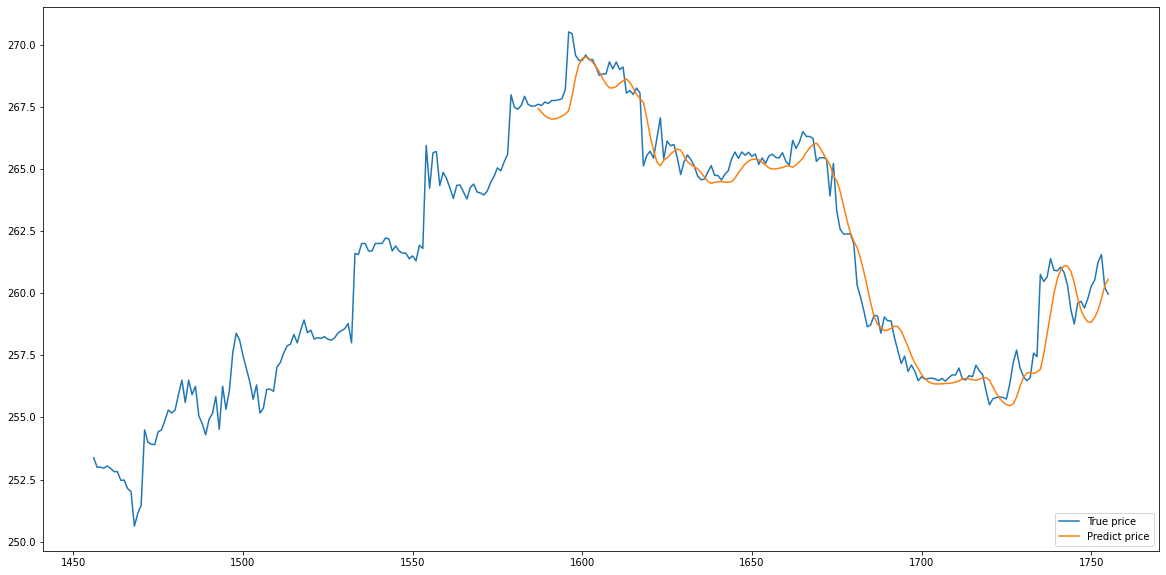

In [92]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [93]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[261.72  ,  -1.2377],
       [261.262 ,  -1.4106],
       [261.74  ,  -1.0884],
       ...,
       [261.5501,   1.5374],
       [260.22  ,   1.0759],
       [259.9587,  -0.3054]])

In [94]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.56033874, 0.40143424],
       [0.54741002, 0.37929312],
       [0.56090332, 0.42055321],
       ...,
       [0.5555427 , 0.75680625],
       [0.51799577, 0.69770777],
       [0.51061962, 0.52082213]])

In [95]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1696
1696


In [96]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1357, 60, 2)
Size validate:  (170, 60, 2)
Size test:  (169, 60, 2)


In [97]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC.h5")

Epoch 1/20
43/43 [==============================] - 29s 256ms/step - loss: 0.0428 - val_loss: 0.0054
Epoch 2/20
43/43 [==============================] - 10s 223ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 3/20
43/43 [==============================] - 10s 235ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/20
43/43 [==============================] - 9s 218ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/20
43/43 [==============================] - 10s 224ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 6/20
43/43 [==============================] - 10s 240ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/20
43/43 [==============================] - 10s 222ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 8/20
43/43 [==============================] - 10s 226ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 9/20
43/43 [==============================] - 9s 221ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/20
43/43 [==============================] - 9s 219ms/step - loss: 0.0016 - val_loss:

In [98]:
model_lstm = load_model('./MODEL/LSTM_ROC.h5')

In [99]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]
predictions

array([267.77206, 267.58694, 267.404  , 267.37186, 267.38876, 267.4801 ,
       267.55756, 267.58627, 267.5928 , 267.68356, 268.53754, 269.35364,
       269.6724 , 269.3497 , 269.06705, 268.97366, 268.9271 , 268.9113 ,
       268.92014, 268.86786, 268.84732, 268.844  , 269.0161 , 269.09402,
       269.22794, 269.22882, 269.21906, 268.87595, 268.54468, 268.19754,
       267.71942, 267.38226, 266.51428, 265.90332, 265.58505, 265.37027,
       265.53293, 266.01825, 266.07138, 266.2172 , 266.24243, 266.20624,
       265.91336, 265.44772, 265.12946, 265.04172, 264.9816 , 265.01416,
       264.90704, 264.73868, 264.5414 , 264.47433, 264.88934, 265.09003,
       265.0977 , 264.9681 , 264.72916, 264.43762, 264.56982, 264.75372,
       264.87787, 265.01965, 265.15903, 265.36713, 265.387  , 265.32724,
       265.15555, 265.09387, 265.0623 , 265.144  , 265.24518, 265.24744,
       265.18237, 265.23395, 265.2027 , 265.13718, 265.32935, 265.44278,
       265.53116, 265.69308, 265.83923, 265.9144 , 

In [100]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date      open      high       low     close    volume  \
1587  2022-06-24 18:00:00  267.5222  267.6000  267.5222  267.6000     342.0   
1588  2022-06-24 18:15:00  267.6000  267.7000  267.5500  267.5500     884.0   
1589  2022-06-24 18:30:00  267.6200  267.7499  267.6200  267.6900    2325.0   
1590  2022-06-24 18:45:00  267.7499  267.7499  267.6300  267.6300    1374.0   
1591  2022-06-24 19:00:00  267.6400  267.8700  267.6400  267.7500    2541.0   
...                   ...       ...       ...       ...       ...       ...   
1751  2022-06-29 14:00:00  260.3800  260.5200  260.0100  260.5200  283685.0   
1752  2022-06-29 14:15:00  260.5400  261.3800  260.4300  261.2500  554627.0   
1753  2022-06-29 14:30:00  261.2800  261.6100  261.0900  261.5501  437153.0   
1754  2022-06-29 14:45:00  261.5400  261.5888  260.1900  260.2200  439656.0   
1755  2022-06-29 15:00:00  260.2300  260.3400  259.9200  259.9587  463893.0   

         ROC       SMA      RSI  Real Middle Band  Real Lower Band  \
1587  1.2677  265.9563  67.8115          265.9563       264.098835   
1588  1.1952  266.1143  67.3575          266.1143       264.333395   
1589  1.3708  266.2953  67.9892          266.2953       264.593234   
1590  1.3635  266.4753  67.4007          266.4753       264.857404   
1591  1.4397  266.6653  67.9841          266.6653       265.150985   
...      ...       ...      ...               ...              ...   
1751  1.5752  259.8138  59.3219          259.8138       259.007236   
1752  1.8122  260.0463  62.6026          260.0463       259.234274   
1753  1.5374  260.2443  63.8638          260.2443       259.516740   
1754  1.0759  260.3828  55.1818          260.3828       259.929074   
1755 -0.3054  260.3430  53.6729          260.3430       259.950919   

      Real Upper Band  predictions  
1587       267.813765   267.772064  
1588       267.895205   267.586945  
1589       267.997366   267.403992  
1590       268.093196   267.371857  
1591       268.179615   267.388763  
...               ...          ...  
1751       260.620364   259.222229  
1752       260.858326   259.780457  
1753       260.971860   260.446167  
1754       260.836526   260.945221  
1755       260.735081   260.935364  

[169 rows x 13 columns]

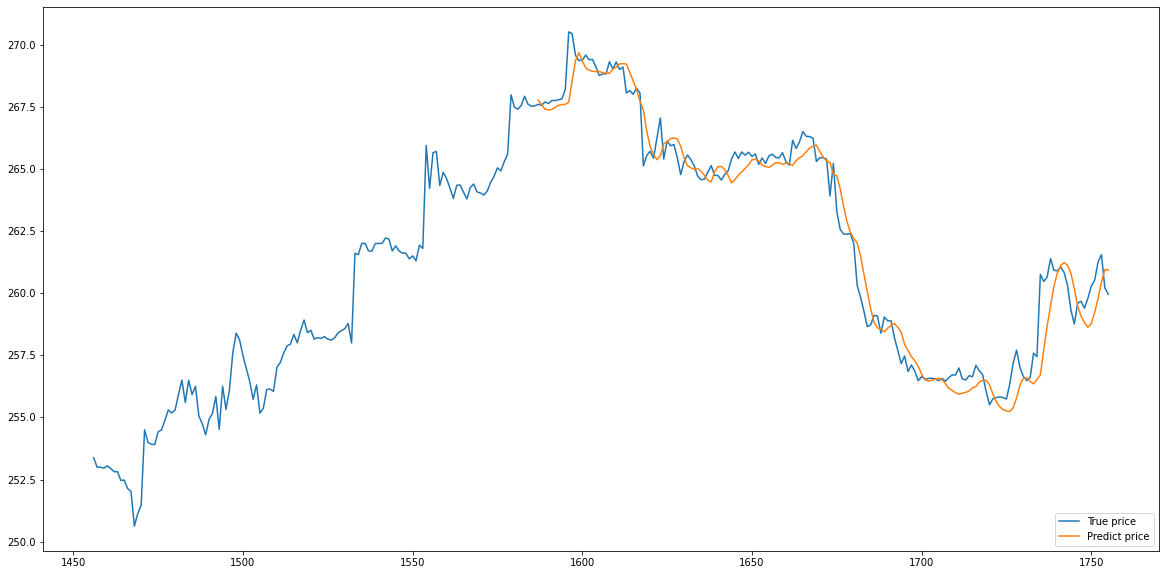

In [101]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/20
43/43 [==============================] - 27s 276ms/step - loss: 0.0241 - val_loss: 0.0039
Epoch 2/20
43/43 [==============================] - 10s 221ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 3/20
43/43 [==============================] - 10s 225ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 4/20
43/43 [==============================] - 9s 219ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 5/20
43/43 [==============================] - 10s 222ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 6/20
43/43 [==============================] - 9s 219ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 7/20
43/43 [==============================] - 10s 222ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/20
43/43 [==============================] - 9s 218ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 9/20
43/43 [==============================] - 9s 219ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 10/20
43/43 [==============================] - 11s 244ms/step - loss: 0.0019 - val_loss: 

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


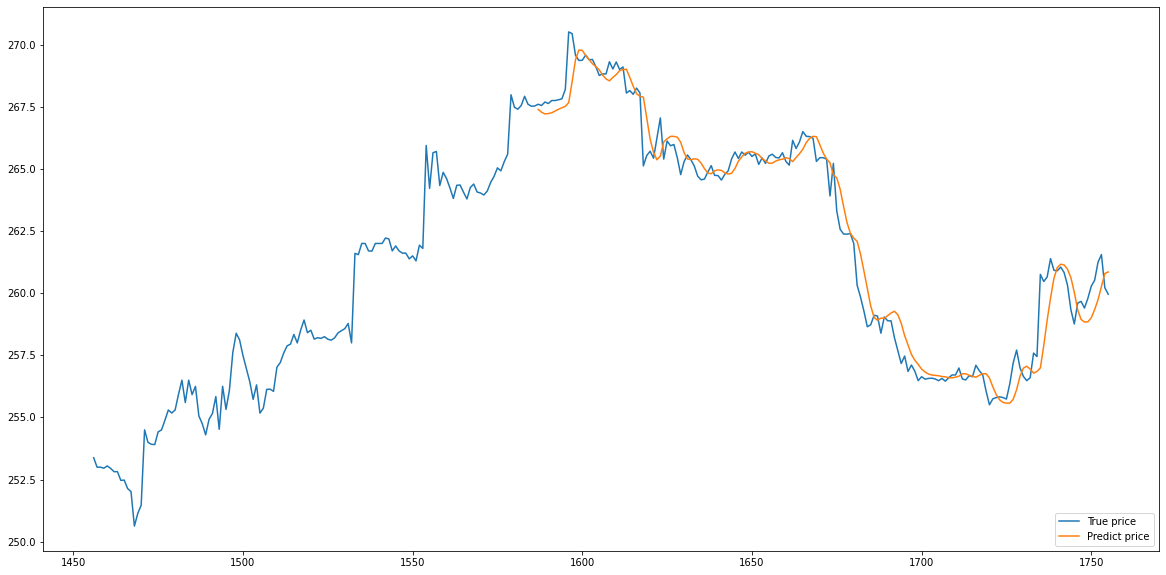

In [102]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/20
43/43 [==============================] - 26s 256ms/step - loss: 0.0479 - val_loss: 0.0029
Epoch 2/20
43/43 [==============================] - 10s 224ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 3/20
43/43 [==============================] - 13s 295ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 4/20
43/43 [==============================] - 9s 212ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 5/20
43/43 [==============================] - 606s 14s/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/20
43/43 [==============================] - 10s 242ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 7/20
43/43 [==============================] - 13s 296ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/20
43/43 [==============================] - 15s 361ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 9/20
43/43 [==============================] - 11s 267ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/20
43/43 [==============================] - 9s 204ms/step - loss: 0.0013 - val_loss:

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


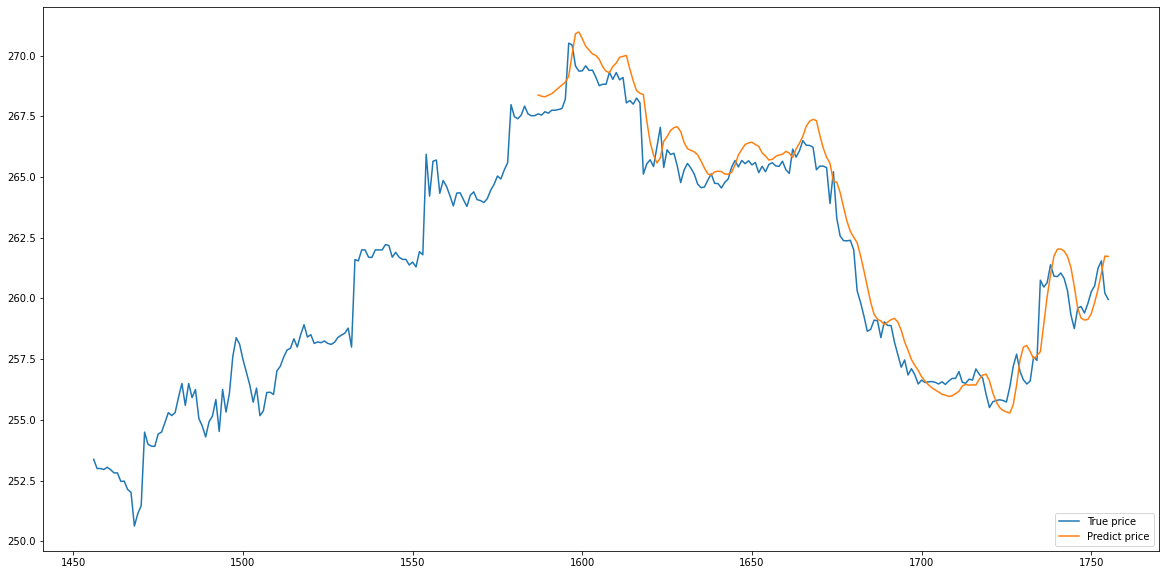

In [103]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/20
43/43 [==============================] - 26s 222ms/step - loss: 0.0161 - val_loss: 0.0030
Epoch 2/20
43/43 [==============================] - 8s 191ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 3/20
43/43 [==============================] - 8s 191ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 4/20
43/43 [==============================] - 8s 188ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 5/20
43/43 [==============================] - 8s 189ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 6/20
43/43 [==============================] - 8s 194ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 7/20
43/43 [==============================] - 8s 191ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 8/20
43/43 [==============================] - 8s 188ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 9/20
43/43 [==============================] - 8s 198ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 10/20
43/43 [==============================] - 8s 189ms/step - loss: 0.0015 - val_loss: 0.002

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


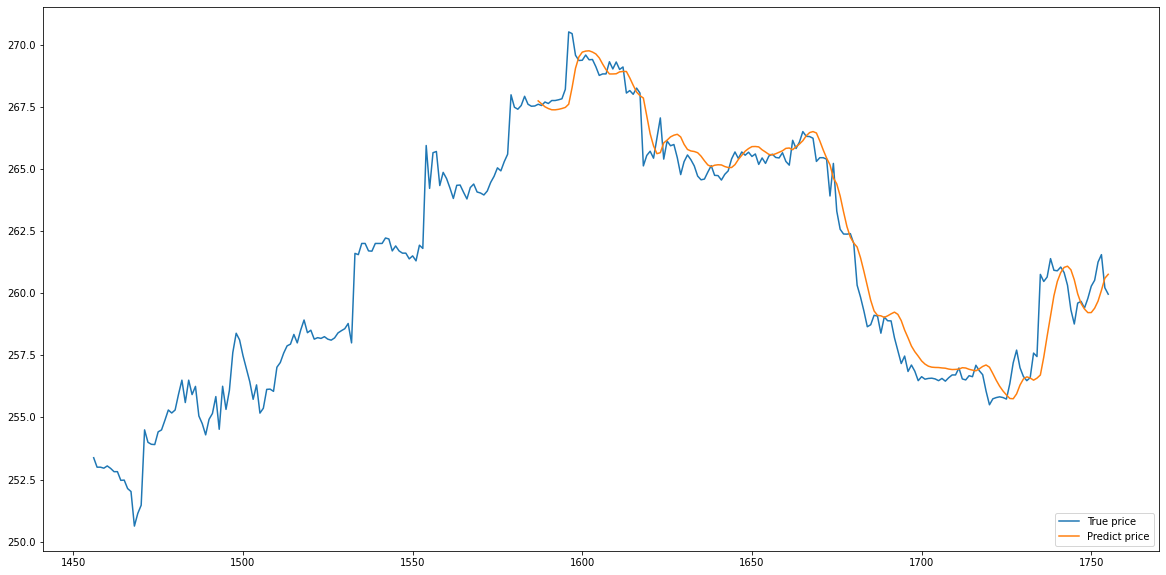

In [104]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/20
43/43 [==============================] - 23s 227ms/step - loss: 0.0158 - val_loss: 0.0035
Epoch 2/20
43/43 [==============================] - 8s 188ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 3/20
43/43 [==============================] - 8s 191ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 4/20
43/43 [==============================] - 8s 187ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 5/20
43/43 [==============================] - 8s 186ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 6/20
43/43 [==============================] - 8s 187ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 7/20
43/43 [==============================] - 8s 186ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 8/20
43/43 [==============================] - 8s 194ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 9/20
43/43 [==============================] - 9s 204ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/20
43/43 [==============================] - 8s 187ms/step - loss: 0.0012 - val_loss: 0.001

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


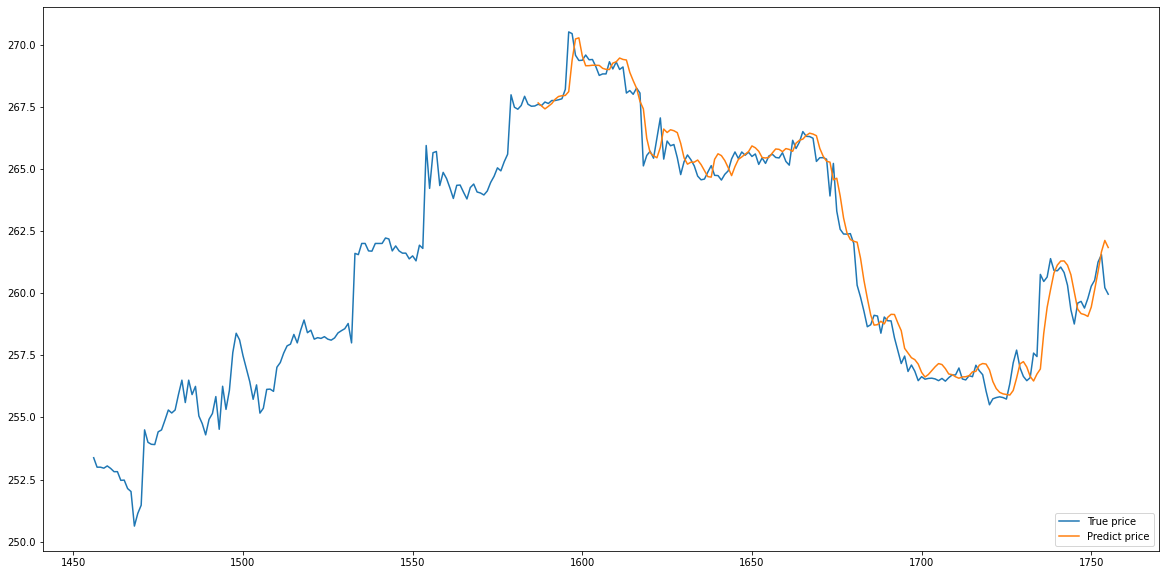

In [105]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/20
43/43 [==============================] - 23s 237ms/step - loss: 0.0306 - val_loss: 0.0042
Epoch 2/20
43/43 [==============================] - 8s 190ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 3/20
43/43 [==============================] - 9s 199ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 4/20
43/43 [==============================] - 8s 186ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/20
43/43 [==============================] - 8s 186ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/20
43/43 [==============================] - 8s 188ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 7/20
43/43 [==============================] - 8s 186ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 8/20
43/43 [==============================] - 8s 188ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 9/20
43/43 [==============================] - 8s 187ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/20
43/43 [==============================] - 8s 193ms/step - loss: 0.0015 - val_loss: 0.001

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


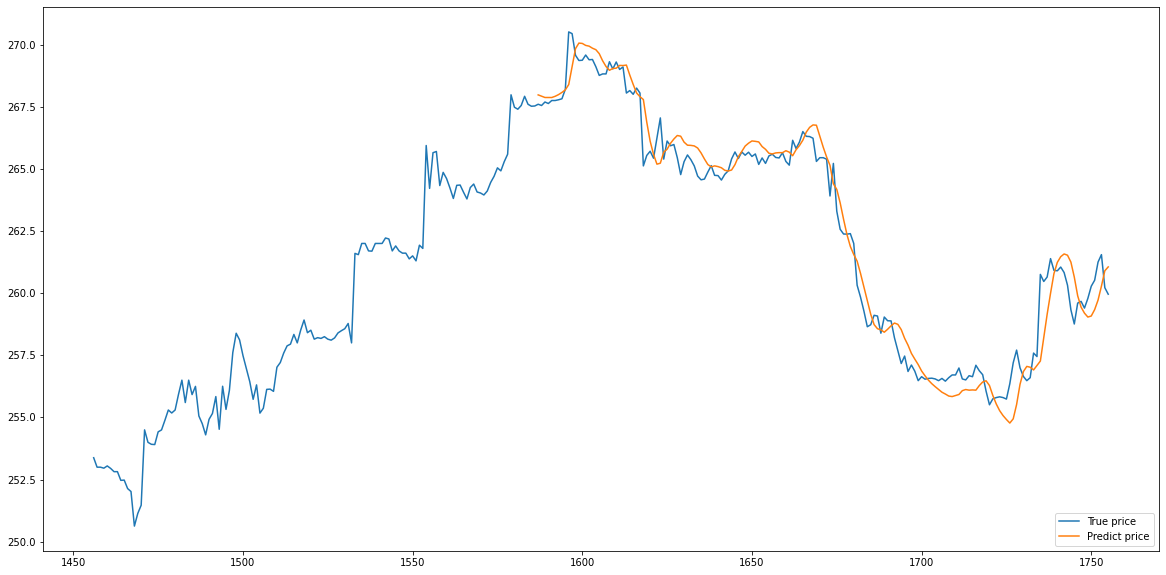

In [106]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/20
43/43 [==============================] - 25s 249ms/step - loss: 0.0206 - val_loss: 0.0035
Epoch 2/20
43/43 [==============================] - 8s 195ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 3/20
43/43 [==============================] - 8s 189ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 4/20
43/43 [==============================] - 8s 187ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 5/20
43/43 [==============================] - 8s 192ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 6/20
43/43 [==============================] - 8s 188ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 7/20
43/43 [==============================] - 8s 189ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 8/20
43/43 [==============================] - 8s 188ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 9/20
43/43 [==============================] - 9s 204ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 10/20
43/43 [==============================] - 8s 190ms/step - loss: 0.0018 - val_loss: 0.002

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


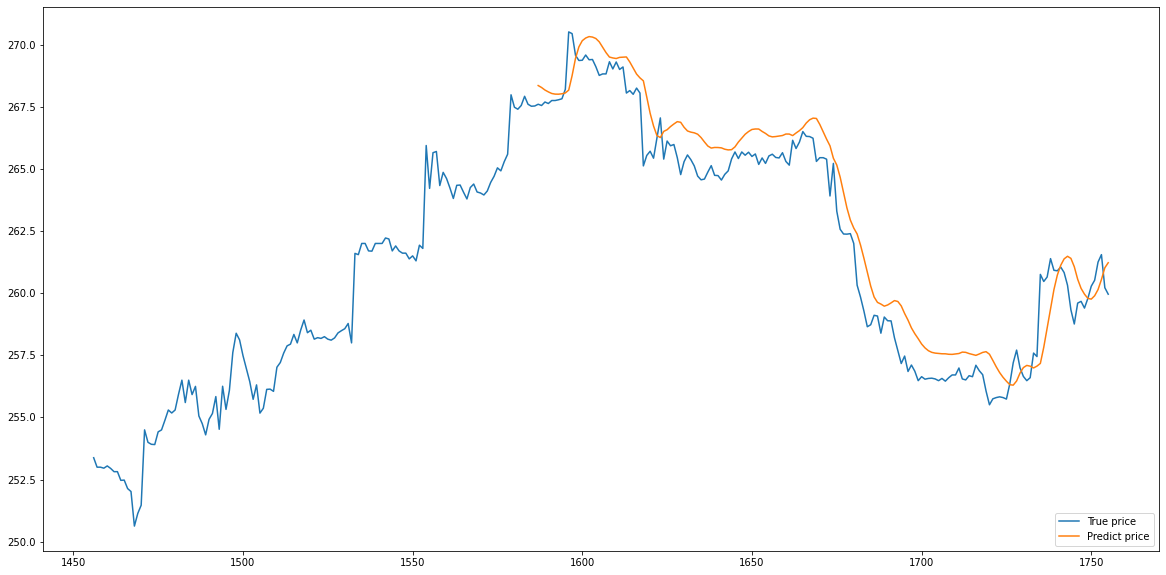

In [107]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/20
43/43 [==============================] - 22s 231ms/step - loss: 0.0293 - val_loss: 0.0018
Epoch 2/20
43/43 [==============================] - 9s 201ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 3/20
43/43 [==============================] - 8s 189ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 4/20
43/43 [==============================] - 8s 189ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 5/20
43/43 [==============================] - 8s 186ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/20
43/43 [==============================] - 8s 190ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/20
43/43 [==============================] - 8s 187ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/20
43/43 [==============================] - 8s 187ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 9/20
43/43 [==============================] - 8s 188ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/20
43/43 [==============================] - 8s 187ms/step - loss: 0.0012 - val_loss: 0.001

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


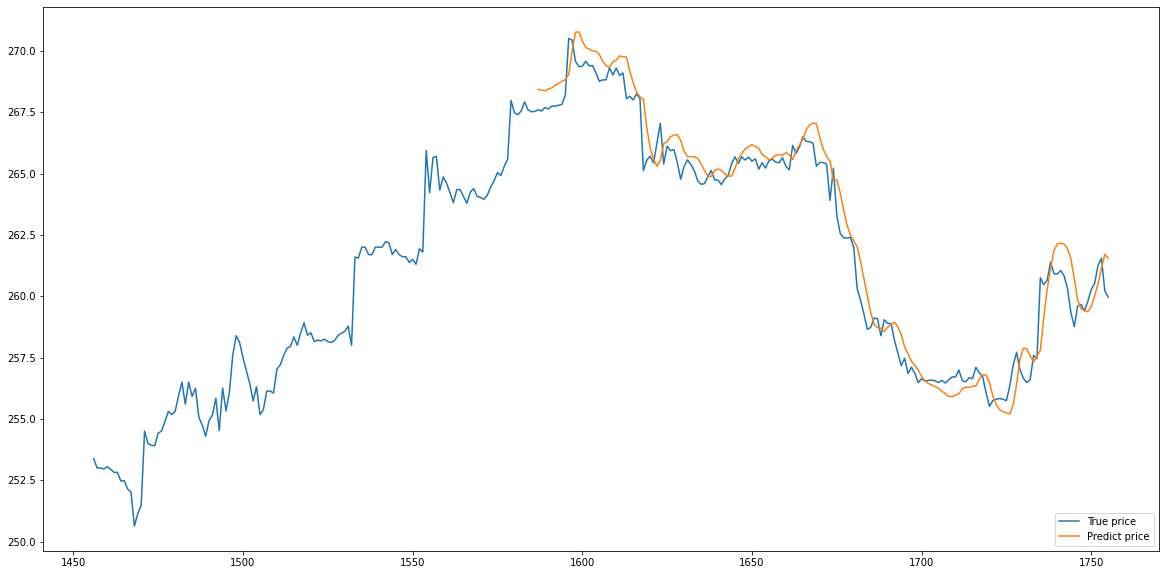

In [108]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/20
43/43 [==============================] - 17s 204ms/step - loss: 0.0389 - val_loss: 0.0051
Epoch 2/20
43/43 [==============================] - 8s 188ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 3/20
43/43 [==============================] - 8s 186ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 4/20
43/43 [==============================] - 8s 187ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 5/20
43/43 [==============================] - 8s 188ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 6/20
43/43 [==============================] - 8s 184ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/20
43/43 [==============================] - 8s 196ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/20
43/43 [==============================] - 8s 186ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 9/20
43/43 [==============================] - 8s 190ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 10/20
43/43 [==============================] - 8s 189ms/step - loss: 0.0015 - val_loss: 0.001

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


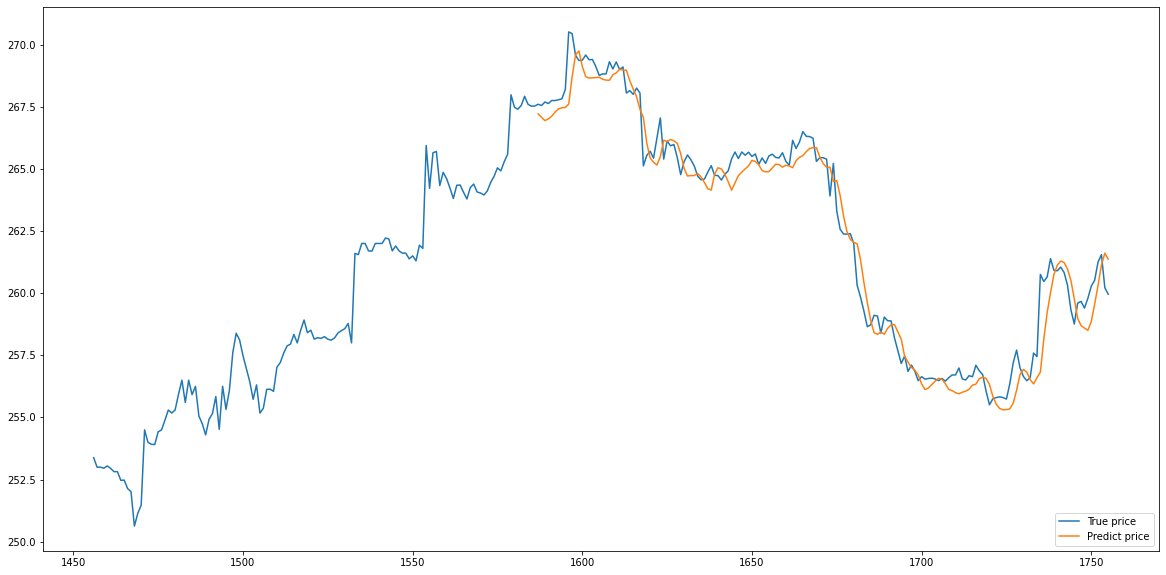

In [109]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/20
43/43 [==============================] - 17s 228ms/step - loss: 0.0259 - val_loss: 0.0020
Epoch 2/20
43/43 [==============================] - 9s 215ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 3/20
43/43 [==============================] - 9s 199ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/20
43/43 [==============================] - 8s 194ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/20
43/43 [==============================] - 9s 203ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 6/20
43/43 [==============================] - 8s 189ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 7/20
43/43 [==============================] - 8s 191ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/20
43/43 [==============================] - 8s 190ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/20
43/43 [==============================] - 8s 190ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/20
43/43 [==============================] - 8s 187ms/step - loss: 0.0012 - val_loss: 0.001

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


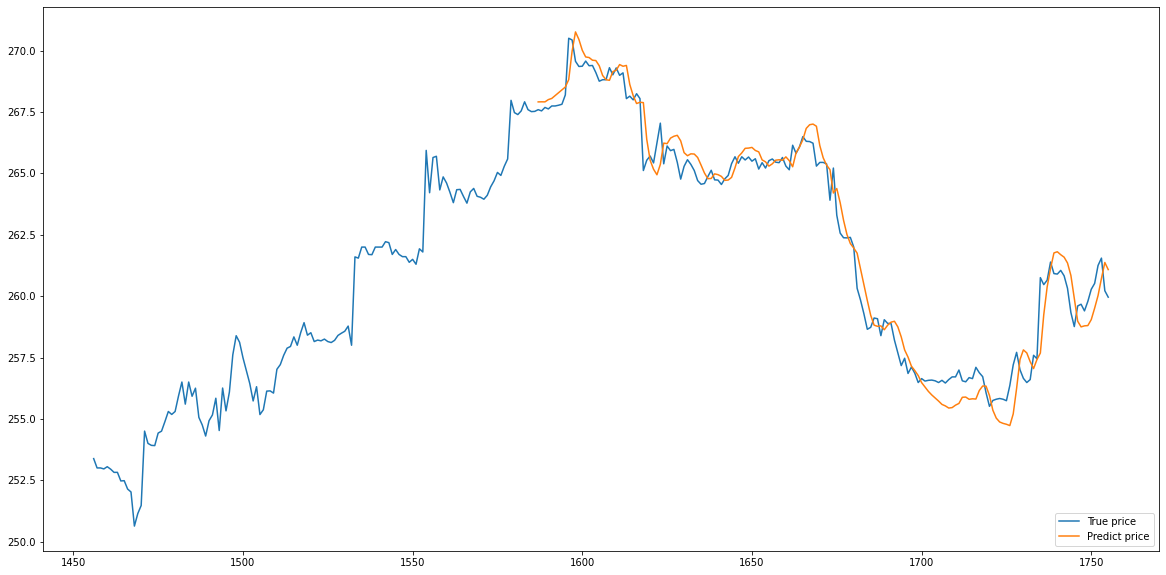

In [110]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/20
43/43 [==============================] - 31s 268ms/step - loss: 0.0299 - val_loss: 0.0020
Epoch 2/20
43/43 [==============================] - 9s 209ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 3/20
43/43 [==============================] - 14s 316ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/20
43/43 [==============================] - 12s 267ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 5/20
43/43 [==============================] - 9s 214ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/20
43/43 [==============================] - 11s 260ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/20
43/43 [==============================] - 9s 215ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 8/20
43/43 [==============================] - 9s 204ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 9/20
43/43 [==============================] - 9s 216ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 10/20
43/43 [==============================] - 8s 198ms/step - loss: 0.0014 - val_loss: 0.

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


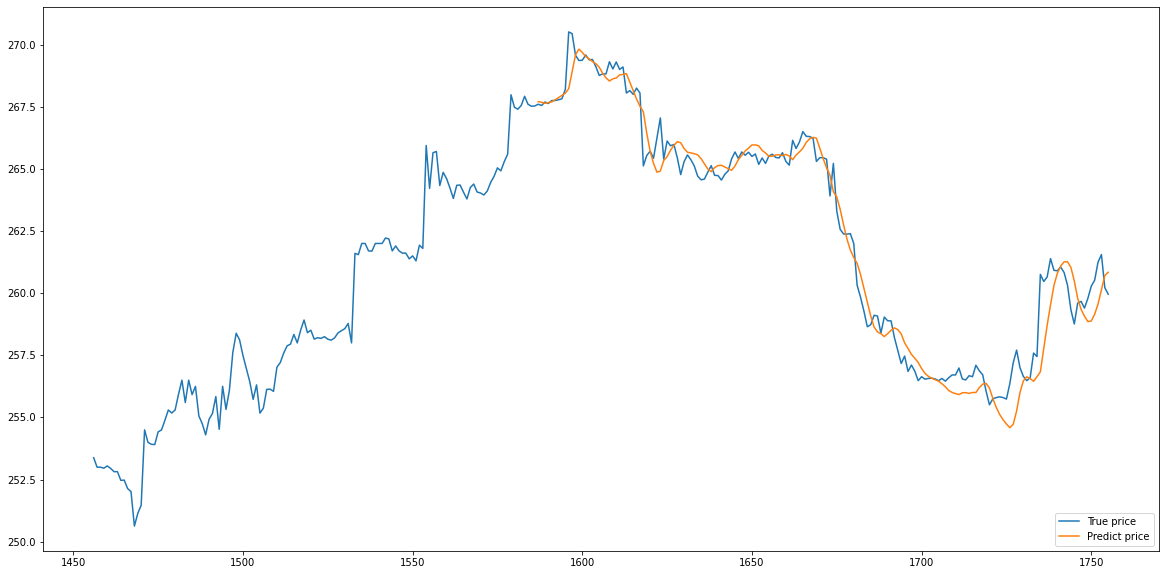

In [111]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/20
43/43 [==============================] - 39s 325ms/step - loss: 0.0211 - val_loss: 0.0029
Epoch 2/20
43/43 [==============================] - 9s 198ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 3/20
43/43 [==============================] - 8s 193ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 4/20
43/43 [==============================] - 8s 193ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/20
43/43 [==============================] - 9s 212ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 6/20
43/43 [==============================] - 12s 270ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/20
43/43 [==============================] - 12s 287ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 8/20
43/43 [==============================] - 8s 193ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 9/20
43/43 [==============================] - 11s 249ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/20
43/43 [==============================] - 10s 234ms/step - loss: 0.0016 - val_loss: 0

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


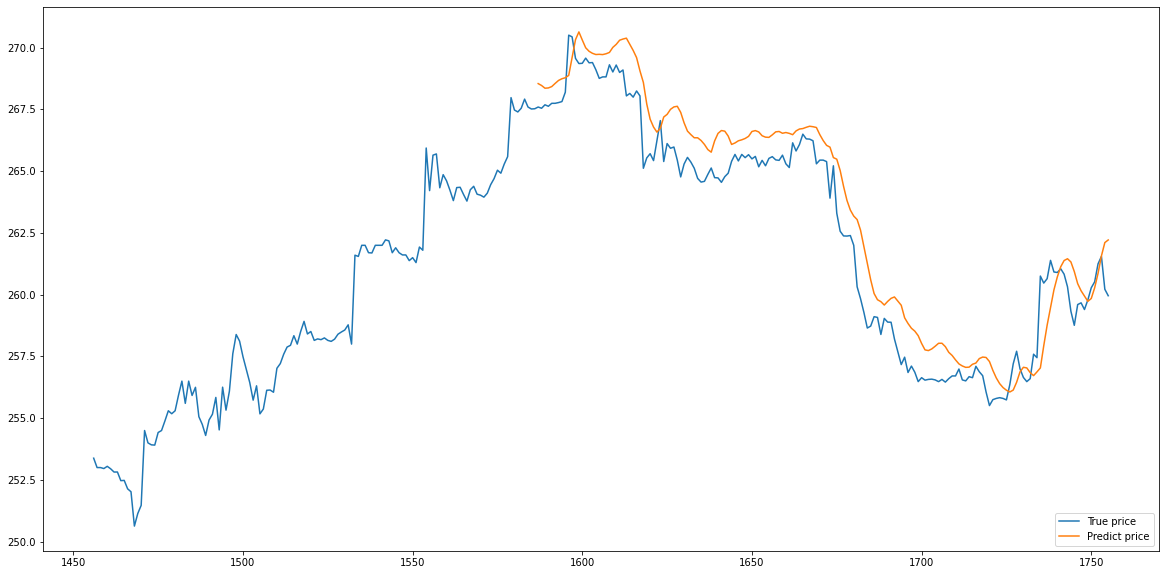

In [112]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/20
43/43 [==============================] - 43s 352ms/step - loss: 0.0505 - val_loss: 0.0052
Epoch 2/20
43/43 [==============================] - 14s 336ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 3/20
43/43 [==============================] - 16s 381ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 4/20
43/43 [==============================] - 12s 279ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 5/20
43/43 [==============================] - 12s 285ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 6/20
43/43 [==============================] - 14s 327ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 7/20
43/43 [==============================] - 10s 233ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 8/20
43/43 [==============================] - 10s 230ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 9/20
43/43 [==============================] - 11s 258ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/20
43/43 [==============================] - 14s 320ms/step - loss: 0.0012 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


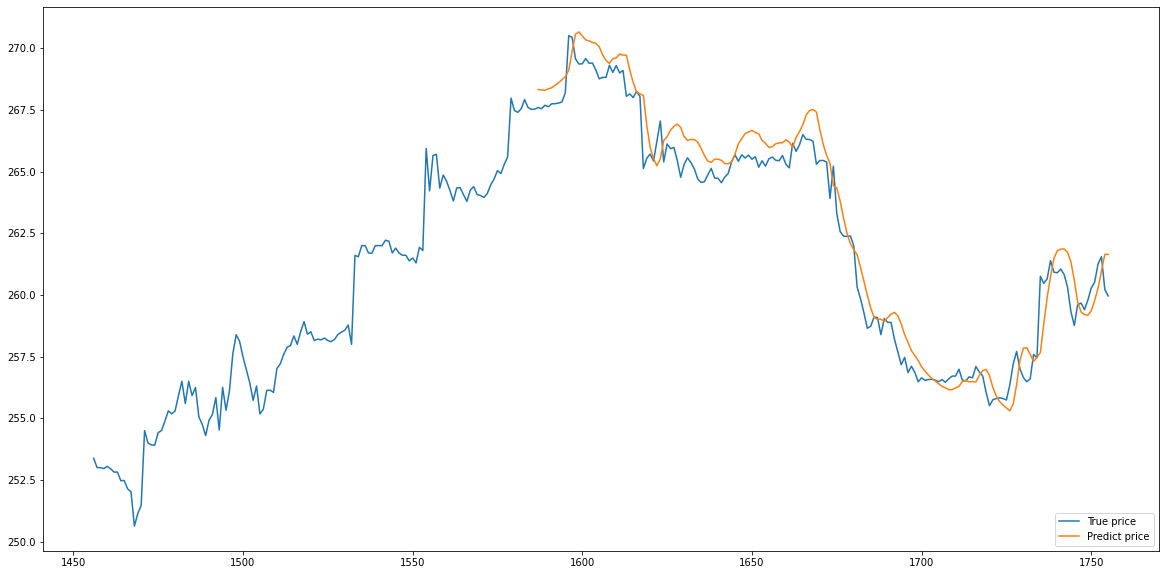

In [113]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/20
43/43 [==============================] - 26s 223ms/step - loss: 0.0405 - val_loss: 0.0043
Epoch 2/20
43/43 [==============================] - 8s 189ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 3/20
43/43 [==============================] - 8s 190ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 4/20
43/43 [==============================] - 8s 192ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/20
43/43 [==============================] - 8s 197ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/20
43/43 [==============================] - 8s 188ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 7/20
43/43 [==============================] - 8s 191ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 8/20
43/43 [==============================] - 8s 192ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/20
43/43 [==============================] - 8s 190ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/20
43/43 [==============================] - 8s 191ms/step - loss: 0.0013 - val_loss: 0.001

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


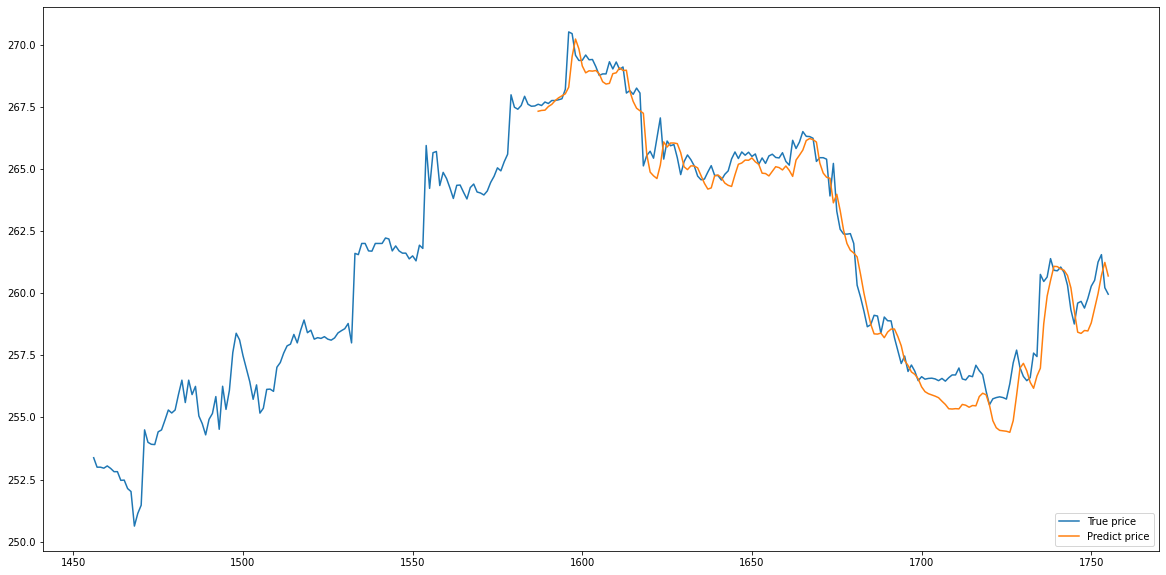

In [114]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/20
43/43 [==============================] - 25s 232ms/step - loss: 0.0303 - val_loss: 0.0037
Epoch 2/20
43/43 [==============================] - 8s 192ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 3/20
43/43 [==============================] - 8s 193ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 4/20
43/43 [==============================] - 8s 192ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 5/20
43/43 [==============================] - 8s 193ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 6/20
43/43 [==============================] - 10s 235ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/20
43/43 [==============================] - 11s 262ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/20
43/43 [==============================] - 10s 241ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 9/20
43/43 [==============================] - 12s 273ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/20
43/43 [==============================] - 10s 230ms/step - loss: 0.0011 - val_loss: 

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


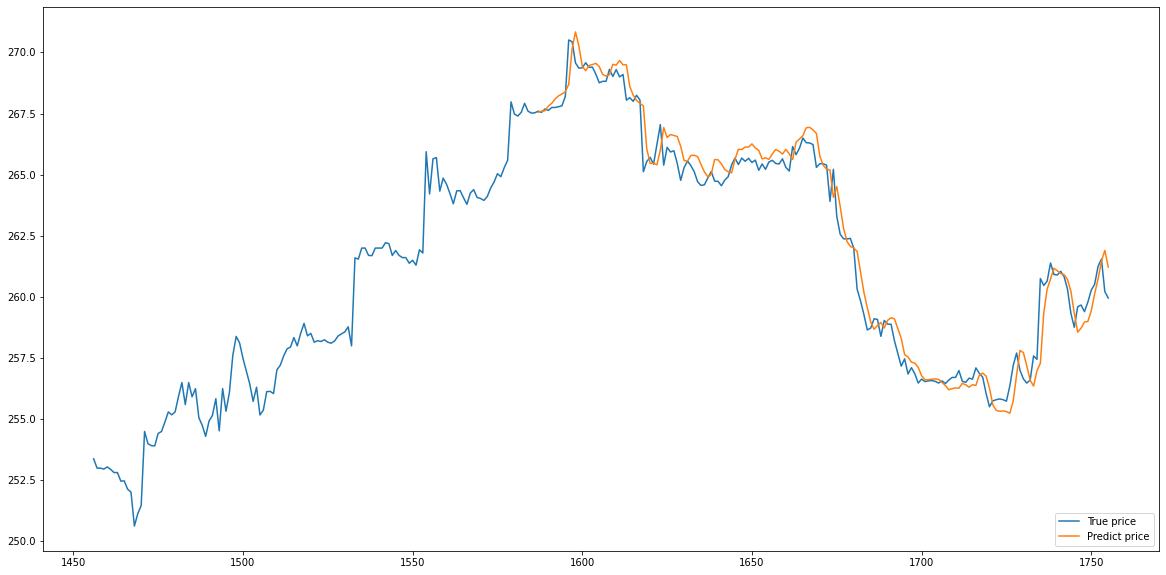

In [115]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### e. Predict Future

In [116]:
def lstm_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.h5'
    model = load_model(modelFileName)
    numDataPoint = int(period / 15)
    
    data = data[indicatorArr].values
    data = data[-60:]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)

    modelInput = scaledData.reshape(-1, scaledData.shape[0], scaledData.shape[1])

    predictedScaledValue = model.predict(modelInput)

    predictedValue = scaler.inverse_transform(np.tile(predictedScaledValue, (1, scaledData.shape[1])))[:, 0]
    
    return predictedValue

## 2. RNN

### a. Prepare Input

In [117]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[261.72  ],
       [261.262 ],
       [261.74  ],
       ...,
       [261.5501],
       [260.22  ],
       [259.9587]])

In [118]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.56033874],
       [0.54741002],
       [0.56090332],
       ...,
       [0.5555427 ],
       [0.51799577],
       [0.51061962]])

In [119]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1696
1696


In [120]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1357, 60, 1)
Size validate:  (170, 60, 1)
Size test:  (169, 60, 1)


### b. Train Model

In [121]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN.h5")

Epoch 1/25
43/43 [==============================] - 58s 601ms/step - loss: 0.0558 - val_loss: 0.0034
Epoch 2/25
43/43 [==============================] - 23s 543ms/step - loss: 0.0090 - val_loss: 0.0036
Epoch 3/25
43/43 [==============================] - 22s 521ms/step - loss: 0.0081 - val_loss: 0.0043
Epoch 4/25
43/43 [==============================] - 24s 548ms/step - loss: 0.0090 - val_loss: 0.0032
Epoch 5/25
43/43 [==============================] - 23s 542ms/step - loss: 0.0077 - val_loss: 0.0036
Epoch 6/25
43/43 [==============================] - 23s 542ms/step - loss: 0.0072 - val_loss: 0.0036
Epoch 7/25
43/43 [==============================] - 24s 553ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 8/25
43/43 [==============================] - 25s 593ms/step - loss: 0.0068 - val_loss: 0.0045
Epoch 9/25
43/43 [==============================] - 33s 758ms/step - loss: 0.0060 - val_loss: 0.0029
Epoch 10/25
43/43 [==============================] - 30s 700ms/step - loss: 0.0062 - val_lo

### c. Test Model

In [122]:
model_rnn = load_model('./MODEL/RNN.h5')

In [123]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [124]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date      open      high       low     close    volume  \
1587  2022-06-24 18:00:00  267.5222  267.6000  267.5222  267.6000     342.0   
1588  2022-06-24 18:15:00  267.6000  267.7000  267.5500  267.5500     884.0   
1589  2022-06-24 18:30:00  267.6200  267.7499  267.6200  267.6900    2325.0   
1590  2022-06-24 18:45:00  267.7499  267.7499  267.6300  267.6300    1374.0   
1591  2022-06-24 19:00:00  267.6400  267.8700  267.6400  267.7500    2541.0   
...                   ...       ...       ...       ...       ...       ...   
1751  2022-06-29 14:00:00  260.3800  260.5200  260.0100  260.5200  283685.0   
1752  2022-06-29 14:15:00  260.5400  261.3800  260.4300  261.2500  554627.0   
1753  2022-06-29 14:30:00  261.2800  261.6100  261.0900  261.5501  437153.0   
1754  2022-06-29 14:45:00  261.5400  261.5888  260.1900  260.2200  439656.0   
1755  2022-06-29 15:00:00  260.2300  260.3400  259.9200  259.9587  463893.0   

         ROC       SMA      RSI  Real Middle Band  Real Lower Band  \
1587  1.2677  265.9563  67.8115          265.9563       264.098835   
1588  1.1952  266.1143  67.3575          266.1143       264.333395   
1589  1.3708  266.2953  67.9892          266.2953       264.593234   
1590  1.3635  266.4753  67.4007          266.4753       264.857404   
1591  1.4397  266.6653  67.9841          266.6653       265.150985   
...      ...       ...      ...               ...              ...   
1751  1.5752  259.8138  59.3219          259.8138       259.007236   
1752  1.8122  260.0463  62.6026          260.0463       259.234274   
1753  1.5374  260.2443  63.8638          260.2443       259.516740   
1754  1.0759  260.3828  55.1818          260.3828       259.929074   
1755 -0.3054  260.3430  53.6729          260.3430       259.950919   

      Real Upper Band  predictions  
1587       267.813765   267.562225  
1588       267.895205   267.637482  
1589       267.997366   267.631409  
1590       268.093196   267.573059  
1591       268.179615   267.489319  
...               ...          ...  
1751       260.620364   259.457245  
1752       260.858326   259.369934  
1753       260.971860   259.433380  
1754       260.836526   259.645508  
1755       260.735081   259.940704  

[169 rows x 13 columns]

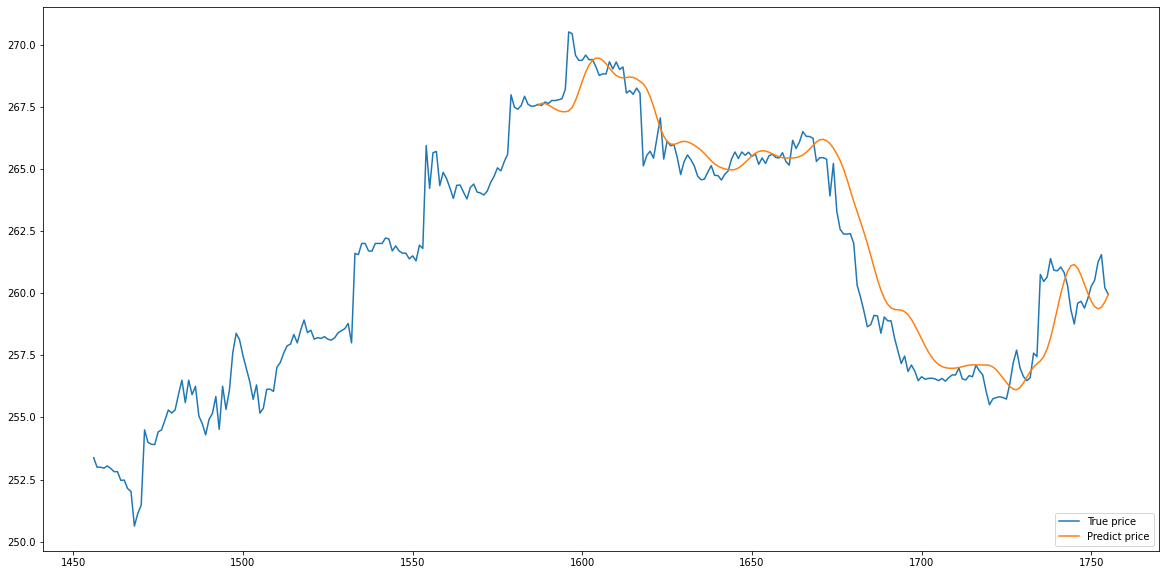

In [125]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [126]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[261.72  ,  -1.2377],
       [261.262 ,  -1.4106],
       [261.74  ,  -1.0884],
       ...,
       [261.5501,   1.5374],
       [260.22  ,   1.0759],
       [259.9587,  -0.3054]])

In [127]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.56033874, 0.40143424],
       [0.54741002, 0.37929312],
       [0.56090332, 0.42055321],
       ...,
       [0.5555427 , 0.75680625],
       [0.51799577, 0.69770777],
       [0.51061962, 0.52082213]])

In [128]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1696
1696


In [129]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1357, 60, 2)
Size validate:  (170, 60, 2)
Size test:  (169, 60, 2)


In [130]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC.h5")

Epoch 1/25
43/43 [==============================] - 49s 485ms/step - loss: 0.0482 - val_loss: 0.0045
Epoch 2/25
43/43 [==============================] - 19s 443ms/step - loss: 0.0092 - val_loss: 0.0058
Epoch 3/25
43/43 [==============================] - 381s 9s/step - loss: 0.0079 - val_loss: 0.0043
Epoch 4/25
43/43 [==============================] - 37s 870ms/step - loss: 0.0076 - val_loss: 0.0037
Epoch 5/25
43/43 [==============================] - 31s 709ms/step - loss: 0.0075 - val_loss: 0.0052
Epoch 6/25
43/43 [==============================] - 29s 680ms/step - loss: 0.0066 - val_loss: 0.0034
Epoch 7/25
43/43 [==============================] - 28s 647ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 8/25
43/43 [==============================] - 29s 670ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 9/25
43/43 [==============================] - 30s 693ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 10/25
43/43 [==============================] - 29s 675ms/step - loss: 0.0060 - val_loss

In [131]:
model_rnn = load_model('./MODEL/RNN_ROC.h5')

In [132]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, 2)))[:, 0]

In [133]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date      open      high       low     close    volume  \
1587  2022-06-24 18:00:00  267.5222  267.6000  267.5222  267.6000     342.0   
1588  2022-06-24 18:15:00  267.6000  267.7000  267.5500  267.5500     884.0   
1589  2022-06-24 18:30:00  267.6200  267.7499  267.6200  267.6900    2325.0   
1590  2022-06-24 18:45:00  267.7499  267.7499  267.6300  267.6300    1374.0   
1591  2022-06-24 19:00:00  267.6400  267.8700  267.6400  267.7500    2541.0   
...                   ...       ...       ...       ...       ...       ...   
1751  2022-06-29 14:00:00  260.3800  260.5200  260.0100  260.5200  283685.0   
1752  2022-06-29 14:15:00  260.5400  261.3800  260.4300  261.2500  554627.0   
1753  2022-06-29 14:30:00  261.2800  261.6100  261.0900  261.5501  437153.0   
1754  2022-06-29 14:45:00  261.5400  261.5888  260.1900  260.2200  439656.0   
1755  2022-06-29 15:00:00  260.2300  260.3400  259.9200  259.9587  463893.0   

         ROC       SMA      RSI  Real Middle Band  Real Lower Band  \
1587  1.2677  265.9563  67.8115          265.9563       264.098835   
1588  1.1952  266.1143  67.3575          266.1143       264.333395   
1589  1.3708  266.2953  67.9892          266.2953       264.593234   
1590  1.3635  266.4753  67.4007          266.4753       264.857404   
1591  1.4397  266.6653  67.9841          266.6653       265.150985   
...      ...       ...      ...               ...              ...   
1751  1.5752  259.8138  59.3219          259.8138       259.007236   
1752  1.8122  260.0463  62.6026          260.0463       259.234274   
1753  1.5374  260.2443  63.8638          260.2443       259.516740   
1754  1.0759  260.3828  55.1818          260.3828       259.929074   
1755 -0.3054  260.3430  53.6729          260.3430       259.950919   

      Real Upper Band  predictions  
1587       267.813765   268.713806  
1588       267.895205   268.767181  
1589       267.997366   268.709442  
1590       268.093196   268.598267  
1591       268.179615   268.479492  
...               ...          ...  
1751       260.620364   259.928284  
1752       260.858326   259.968292  
1753       260.971860   260.218231  
1754       260.836526   260.619720  
1755       260.735081   261.042175  

[169 rows x 13 columns]

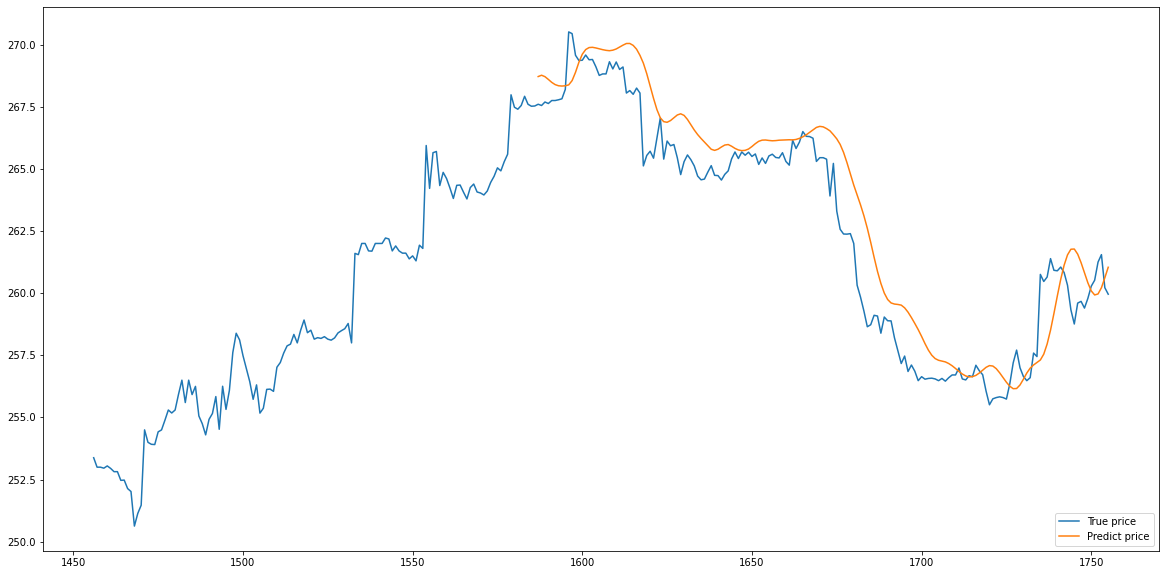

In [134]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/25
43/43 [==============================] - 35s 434ms/step - loss: 0.0493 - val_loss: 0.0084
Epoch 2/25
43/43 [==============================] - 17s 396ms/step - loss: 0.0101 - val_loss: 0.0058
Epoch 3/25
43/43 [==============================] - 18s 426ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 4/25
43/43 [==============================] - 21s 500ms/step - loss: 0.0083 - val_loss: 0.0034
Epoch 5/25
43/43 [==============================] - 19s 437ms/step - loss: 0.0077 - val_loss: 0.0037
Epoch 6/25
43/43 [==============================] - 18s 422ms/step - loss: 0.0073 - val_loss: 0.0043
Epoch 7/25
43/43 [==============================] - 17s 389ms/step - loss: 0.0068 - val_loss: 0.0031
Epoch 8/25
43/43 [==============================] - 17s 405ms/step - loss: 0.0062 - val_loss: 0.0029
Epoch 9/25
43/43 [==============================] - 17s 396ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 10/25
43/43 [==============================] - 17s 397ms/step - loss: 0.0059 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


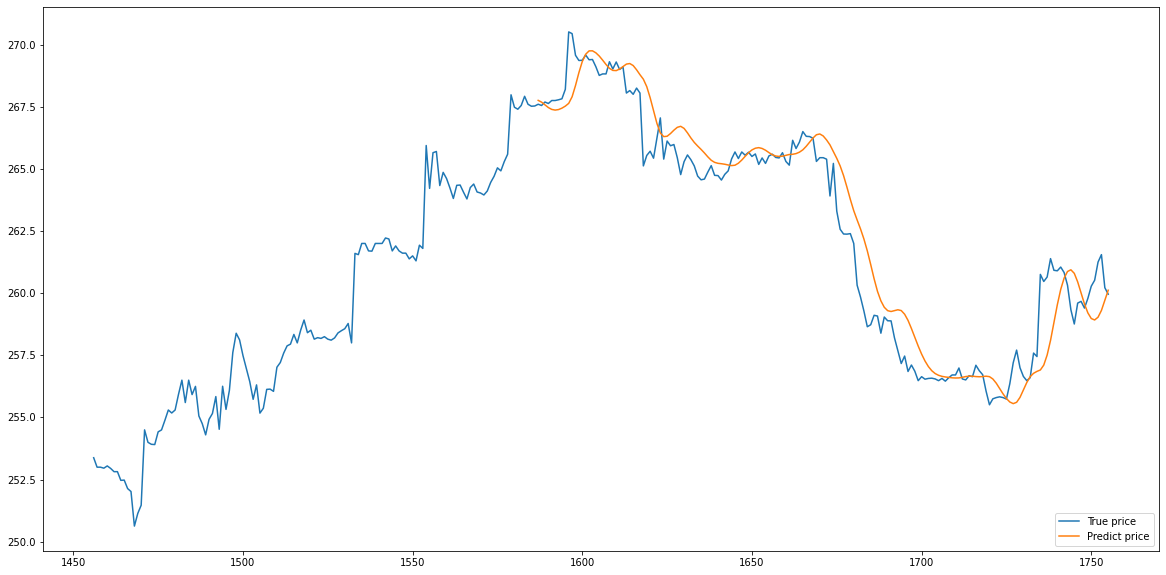

In [135]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_SMA.h5")

model_rnn = load_model('./MODEL/RNN_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/25
43/43 [==============================] - 33s 427ms/step - loss: 0.0429 - val_loss: 0.0042
Epoch 2/25
43/43 [==============================] - 17s 405ms/step - loss: 0.0089 - val_loss: 0.0035
Epoch 3/25
43/43 [==============================] - 17s 405ms/step - loss: 0.0074 - val_loss: 0.0046
Epoch 4/25
43/43 [==============================] - 18s 412ms/step - loss: 0.0069 - val_loss: 0.0033
Epoch 5/25
43/43 [==============================] - 17s 395ms/step - loss: 0.0071 - val_loss: 0.0031
Epoch 6/25
43/43 [==============================] - 17s 405ms/step - loss: 0.0066 - val_loss: 0.0046
Epoch 7/25
43/43 [==============================] - 17s 400ms/step - loss: 0.0060 - val_loss: 0.0043
Epoch 8/25
43/43 [==============================] - 17s 390ms/step - loss: 0.0060 - val_loss: 0.0050
Epoch 9/25
43/43 [==============================] - 17s 403ms/step - loss: 0.0060 - val_loss: 0.0034
Epoch 10/25
43/43 [==============================] - 17s 396ms/step - loss: 0.0062 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


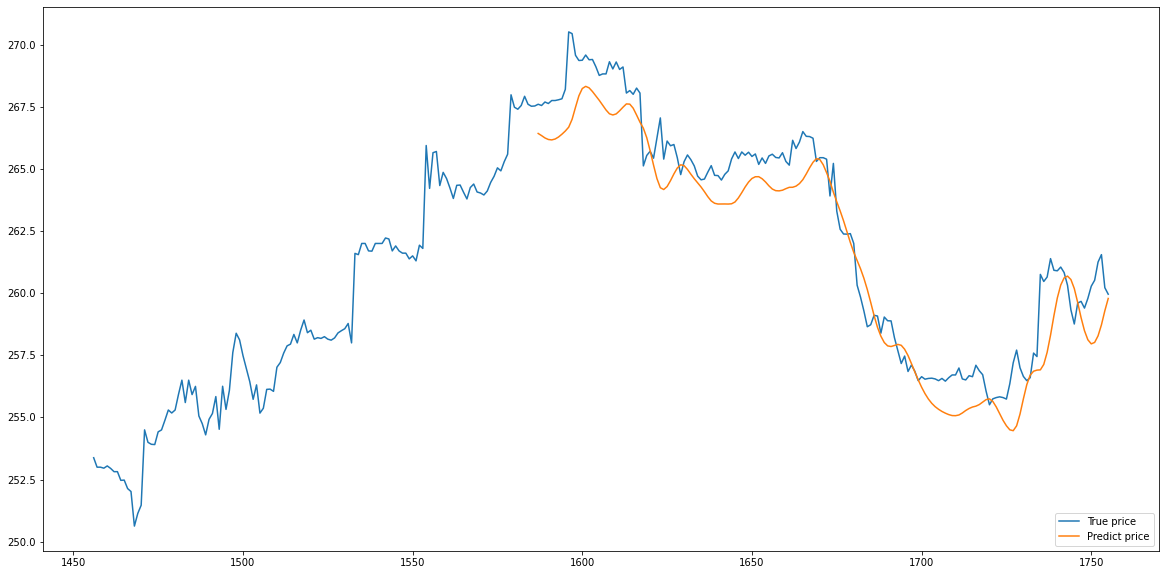

In [136]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI.h5")

model_rnn = load_model('./MODEL/RNN_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/25
43/43 [==============================] - 33s 429ms/step - loss: 0.0426 - val_loss: 0.0079
Epoch 2/25
43/43 [==============================] - 17s 400ms/step - loss: 0.0100 - val_loss: 0.0051
Epoch 3/25
43/43 [==============================] - 17s 392ms/step - loss: 0.0092 - val_loss: 0.0041
Epoch 4/25
43/43 [==============================] - 18s 413ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 5/25
43/43 [==============================] - 19s 441ms/step - loss: 0.0075 - val_loss: 0.0090
Epoch 6/25
43/43 [==============================] - 17s 406ms/step - loss: 0.0071 - val_loss: 0.0042
Epoch 7/25
43/43 [==============================] - 18s 430ms/step - loss: 0.0065 - val_loss: 0.0052
Epoch 8/25
43/43 [==============================] - 17s 402ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 9/25
43/43 [==============================] - 17s 398ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 10/25
43/43 [==============================] - 18s 409ms/step - loss: 0.0061 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


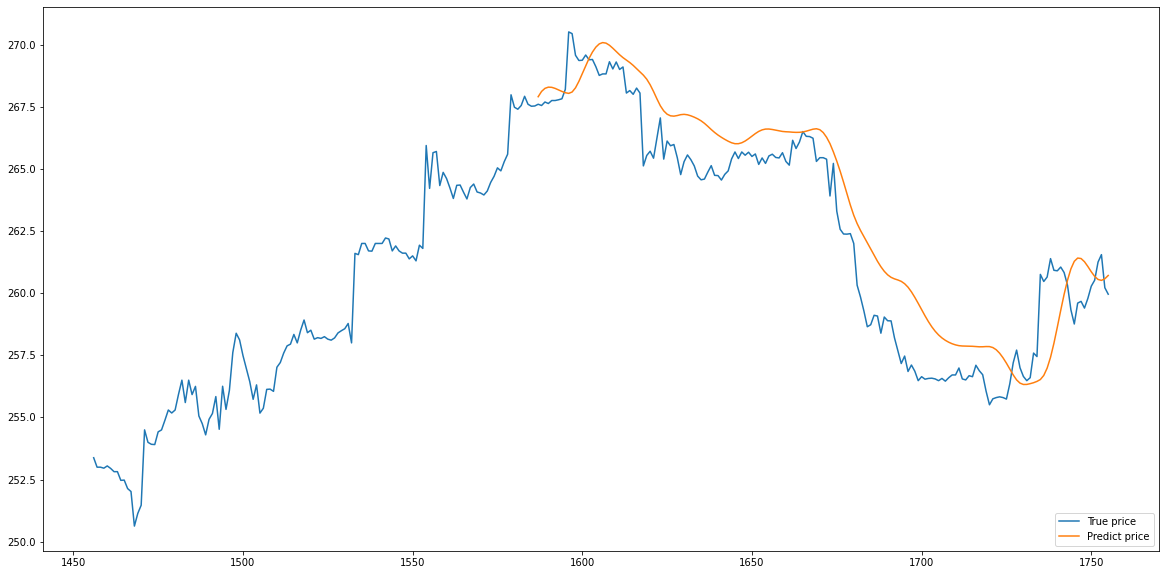

In [137]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/25
43/43 [==============================] - 35s 429ms/step - loss: 0.0416 - val_loss: 0.0061
Epoch 2/25
43/43 [==============================] - 17s 389ms/step - loss: 0.0089 - val_loss: 0.0043
Epoch 3/25
43/43 [==============================] - 17s 388ms/step - loss: 0.0077 - val_loss: 0.0065
Epoch 4/25
43/43 [==============================] - 17s 389ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 5/25
43/43 [==============================] - 17s 387ms/step - loss: 0.0068 - val_loss: 0.0051
Epoch 6/25
43/43 [==============================] - 17s 389ms/step - loss: 0.0075 - val_loss: 0.0044
Epoch 7/25
43/43 [==============================] - 17s 385ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 8/25
43/43 [==============================] - 17s 388ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 9/25
43/43 [==============================] - 17s 388ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 10/25
43/43 [==============================] - 17s 385ms/step - loss: 0.0060 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


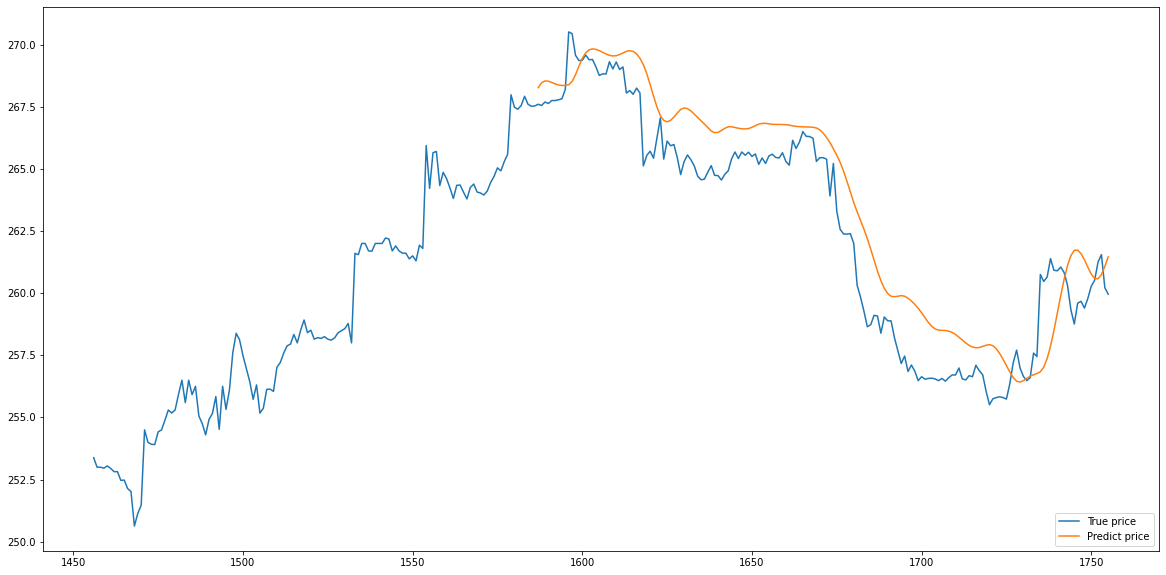

In [138]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/25
43/43 [==============================] - 34s 425ms/step - loss: 0.0447 - val_loss: 0.0048
Epoch 2/25
43/43 [==============================] - 17s 393ms/step - loss: 0.0094 - val_loss: 0.0084
Epoch 3/25
43/43 [==============================] - 17s 391ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 4/25
43/43 [==============================] - 17s 389ms/step - loss: 0.0078 - val_loss: 0.0046
Epoch 5/25
43/43 [==============================] - 17s 386ms/step - loss: 0.0070 - val_loss: 0.0051
Epoch 6/25
43/43 [==============================] - 17s 385ms/step - loss: 0.0065 - val_loss: 0.0038
Epoch 7/25
43/43 [==============================] - 17s 387ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 8/25
43/43 [==============================] - 17s 397ms/step - loss: 0.0056 - val_loss: 0.0046
Epoch 9/25
43/43 [==============================] - 17s 387ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 10/25
43/43 [==============================] - 17s 386ms/step - loss: 0.0056 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


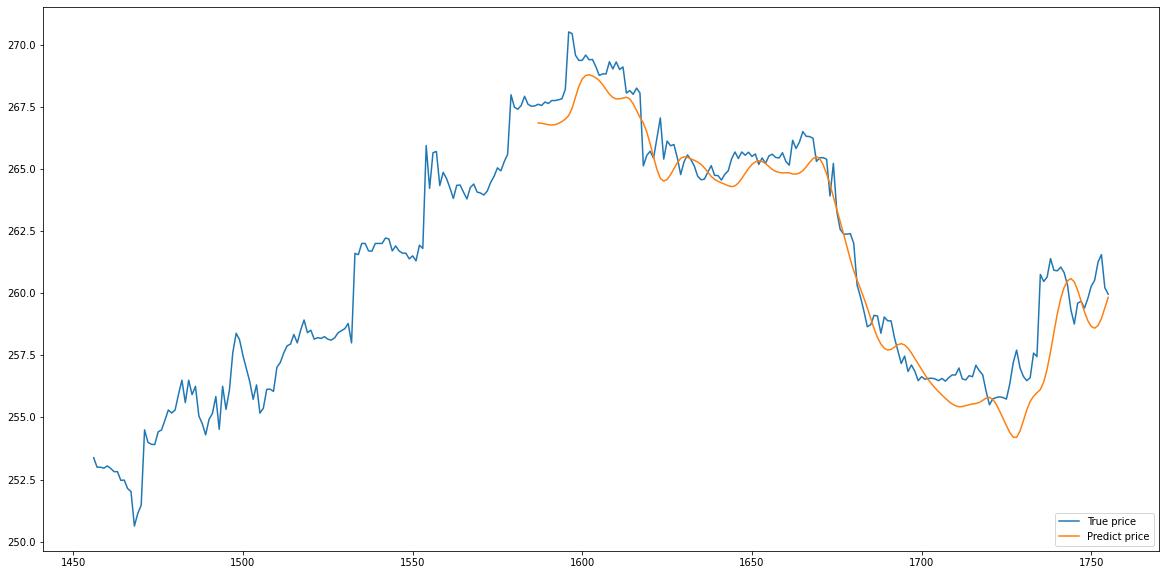

In [139]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/25
43/43 [==============================] - 34s 423ms/step - loss: 0.0411 - val_loss: 0.0051
Epoch 2/25
43/43 [==============================] - 19s 446ms/step - loss: 0.0111 - val_loss: 0.0091
Epoch 3/25
43/43 [==============================] - 27s 641ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 4/25
43/43 [==============================] - 27s 643ms/step - loss: 0.0082 - val_loss: 0.0050
Epoch 5/25
43/43 [==============================] - 28s 655ms/step - loss: 0.0070 - val_loss: 0.0052
Epoch 6/25
43/43 [==============================] - 28s 654ms/step - loss: 0.0079 - val_loss: 0.0055
Epoch 7/25
43/43 [==============================] - 29s 685ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 8/25
43/43 [==============================] - 29s 682ms/step - loss: 0.0064 - val_loss: 0.0048
Epoch 9/25
43/43 [==============================] - 29s 684ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 10/25
43/43 [==============================] - 27s 634ms/step - loss: 0.0062 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


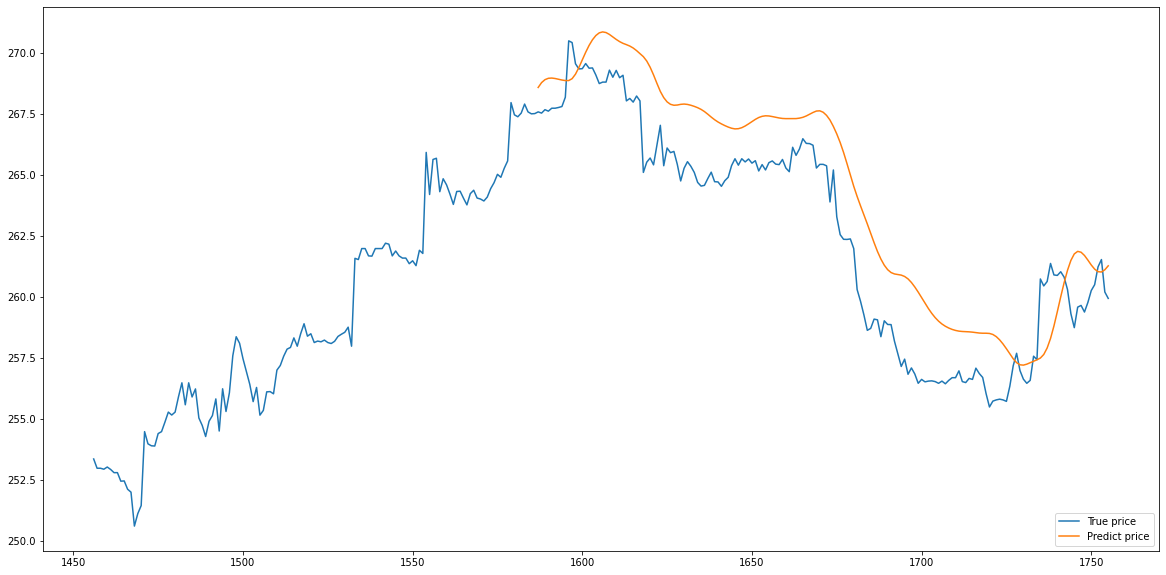

In [140]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/25
43/43 [==============================] - 57s 434ms/step - loss: 0.0634 - val_loss: 0.0063
Epoch 2/25
43/43 [==============================] - 18s 412ms/step - loss: 0.0094 - val_loss: 0.0071
Epoch 3/25
43/43 [==============================] - 18s 406ms/step - loss: 0.0080 - val_loss: 0.0031
Epoch 4/25
43/43 [==============================] - 18s 413ms/step - loss: 0.0077 - val_loss: 0.0038
Epoch 5/25
43/43 [==============================] - 18s 408ms/step - loss: 0.0071 - val_loss: 0.0041
Epoch 6/25
43/43 [==============================] - 18s 409ms/step - loss: 0.0076 - val_loss: 0.0053
Epoch 7/25
43/43 [==============================] - 18s 409ms/step - loss: 0.0064 - val_loss: 0.0035
Epoch 8/25
43/43 [==============================] - 18s 418ms/step - loss: 0.0063 - val_loss: 0.0043
Epoch 9/25
43/43 [==============================] - 18s 410ms/step - loss: 0.0058 - val_loss: 0.0024
Epoch 10/25
43/43 [==============================] - 18s 417ms/step - loss: 0.0056 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


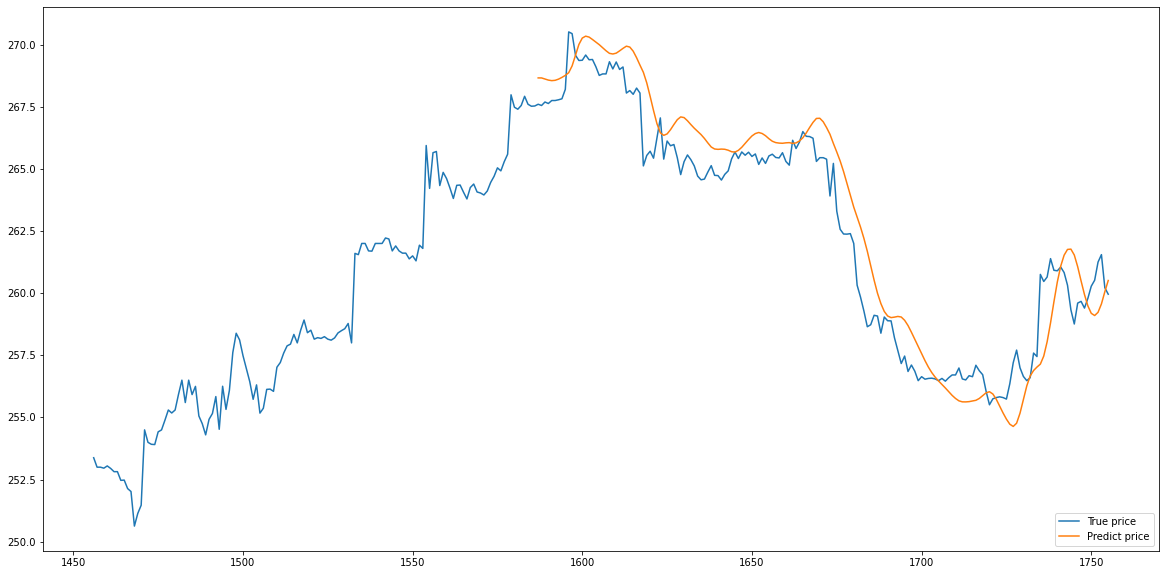

In [141]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/25
43/43 [==============================] - 37s 468ms/step - loss: 0.0483 - val_loss: 0.0086
Epoch 2/25
43/43 [==============================] - 19s 450ms/step - loss: 0.0096 - val_loss: 0.0033
Epoch 3/25
43/43 [==============================] - 19s 450ms/step - loss: 0.0086 - val_loss: 0.0038
Epoch 4/25
43/43 [==============================] - 19s 435ms/step - loss: 0.0071 - val_loss: 0.0033
Epoch 5/25
43/43 [==============================] - 19s 440ms/step - loss: 0.0076 - val_loss: 0.0033
Epoch 6/25
43/43 [==============================] - 18s 430ms/step - loss: 0.0071 - val_loss: 0.0029
Epoch 7/25
43/43 [==============================] - 19s 452ms/step - loss: 0.0072 - val_loss: 0.0059
Epoch 8/25
43/43 [==============================] - 18s 417ms/step - loss: 0.0064 - val_loss: 0.0026
Epoch 9/25
43/43 [==============================] - 18s 418ms/step - loss: 0.0063 - val_loss: 0.0026
Epoch 10/25
43/43 [==============================] - 19s 440ms/step - loss: 0.0061 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


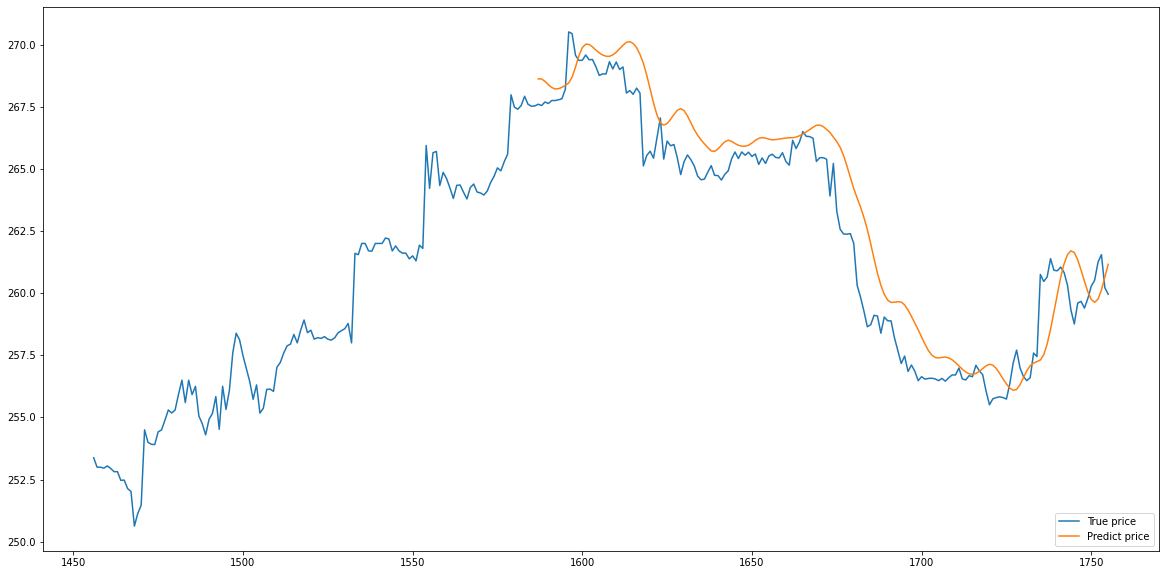

In [142]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/25
43/43 [==============================] - 38s 518ms/step - loss: 0.0499 - val_loss: 0.0038
Epoch 2/25
43/43 [==============================] - 20s 463ms/step - loss: 0.0104 - val_loss: 0.0036
Epoch 3/25
43/43 [==============================] - 19s 443ms/step - loss: 0.0081 - val_loss: 0.0036
Epoch 4/25
43/43 [==============================] - 20s 454ms/step - loss: 0.0071 - val_loss: 0.0032
Epoch 5/25
43/43 [==============================] - 19s 441ms/step - loss: 0.0071 - val_loss: 0.0029
Epoch 6/25
43/43 [==============================] - 19s 443ms/step - loss: 0.0067 - val_loss: 0.0026
Epoch 7/25
43/43 [==============================] - 19s 440ms/step - loss: 0.0067 - val_loss: 0.0031
Epoch 8/25
43/43 [==============================] - 20s 455ms/step - loss: 0.0069 - val_loss: 0.0026
Epoch 9/25
43/43 [==============================] - 19s 438ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 10/25
43/43 [==============================] - 20s 456ms/step - loss: 0.0054 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


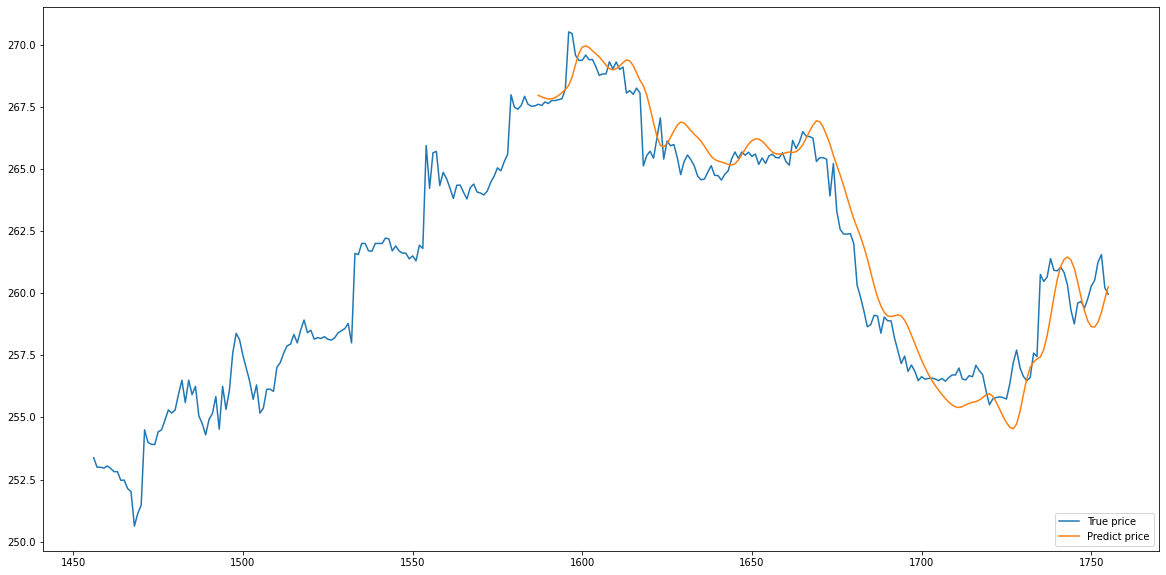

In [143]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/25
43/43 [==============================] - 40s 475ms/step - loss: 0.0362 - val_loss: 0.0039
Epoch 2/25
43/43 [==============================] - 20s 461ms/step - loss: 0.0094 - val_loss: 0.0038
Epoch 3/25
43/43 [==============================] - 21s 485ms/step - loss: 0.0081 - val_loss: 0.0043
Epoch 4/25
43/43 [==============================] - 19s 447ms/step - loss: 0.0072 - val_loss: 0.0032
Epoch 5/25
43/43 [==============================] - 20s 454ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 6/25
43/43 [==============================] - 19s 439ms/step - loss: 0.0069 - val_loss: 0.0046
Epoch 7/25
43/43 [==============================] - 19s 431ms/step - loss: 0.0061 - val_loss: 0.0044
Epoch 8/25
43/43 [==============================] - 19s 433ms/step - loss: 0.0062 - val_loss: 0.0041
Epoch 9/25
43/43 [==============================] - 19s 449ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 10/25
43/43 [==============================] - 19s 438ms/step - loss: 0.0055 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


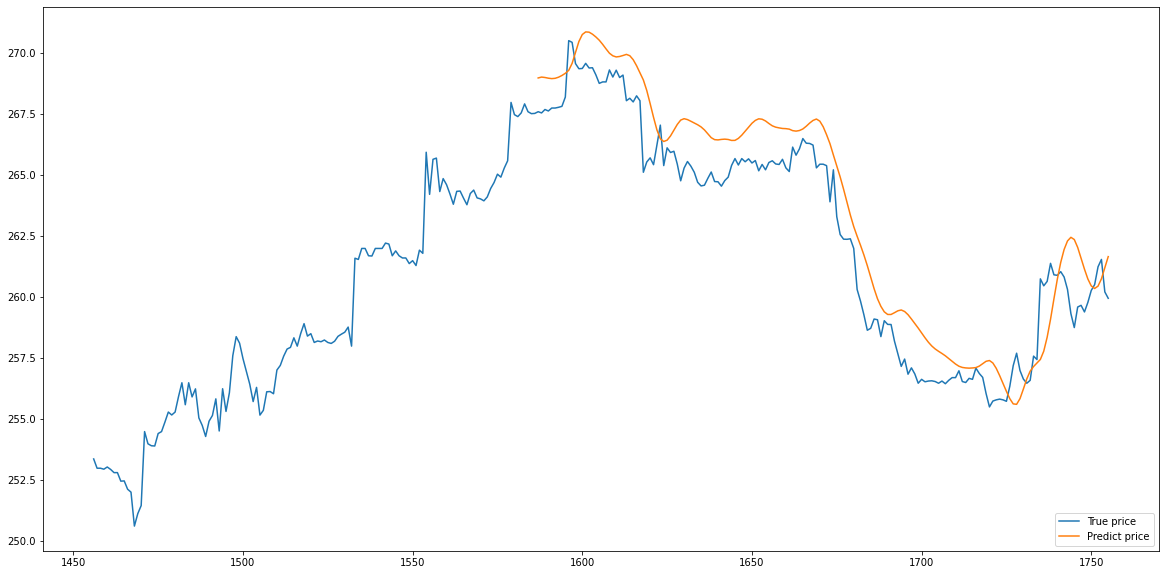

In [144]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/25
43/43 [==============================] - 34s 441ms/step - loss: 0.0324 - val_loss: 0.0091
Epoch 2/25
43/43 [==============================] - 17s 402ms/step - loss: 0.0100 - val_loss: 0.0053
Epoch 3/25
43/43 [==============================] - 17s 407ms/step - loss: 0.0079 - val_loss: 0.0042
Epoch 4/25
43/43 [==============================] - 20s 468ms/step - loss: 0.0073 - val_loss: 0.0045
Epoch 5/25
43/43 [==============================] - 20s 457ms/step - loss: 0.0070 - val_loss: 0.0050
Epoch 6/25
43/43 [==============================] - 19s 432ms/step - loss: 0.0069 - val_loss: 0.0040
Epoch 7/25
43/43 [==============================] - 19s 445ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 8/25
43/43 [==============================] - 19s 442ms/step - loss: 0.0059 - val_loss: 0.0048
Epoch 9/25
43/43 [==============================] - 19s 436ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 10/25
43/43 [==============================] - 19s 433ms/step - loss: 0.0066 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


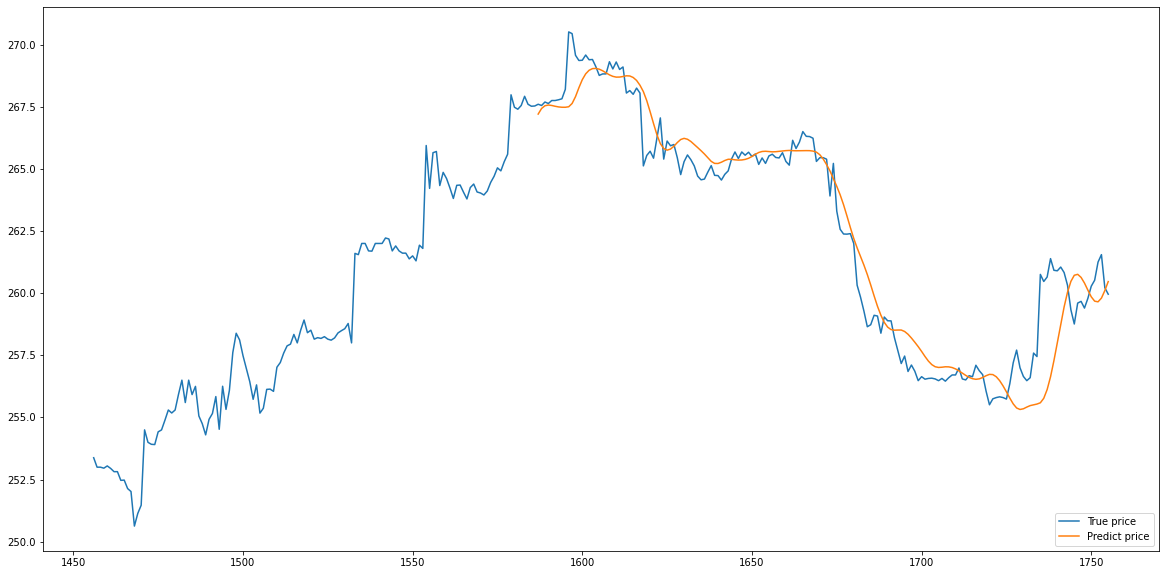

In [145]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/25
43/43 [==============================] - 35s 445ms/step - loss: 0.0563 - val_loss: 0.0037
Epoch 2/25
43/43 [==============================] - 17s 403ms/step - loss: 0.0114 - val_loss: 0.0035
Epoch 3/25
43/43 [==============================] - 17s 406ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 4/25
43/43 [==============================] - 17s 403ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 5/25
43/43 [==============================] - 18s 416ms/step - loss: 0.0070 - val_loss: 0.0047
Epoch 6/25
43/43 [==============================] - 18s 411ms/step - loss: 0.0067 - val_loss: 0.0043
Epoch 7/25
43/43 [==============================] - 17s 405ms/step - loss: 0.0063 - val_loss: 0.0032
Epoch 8/25
43/43 [==============================] - 17s 404ms/step - loss: 0.0056 - val_loss: 0.0042
Epoch 9/25
43/43 [==============================] - 17s 403ms/step - loss: 0.0053 - val_loss: 0.0041
Epoch 10/25
43/43 [==============================] - 18s 407ms/step - loss: 0.0063 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


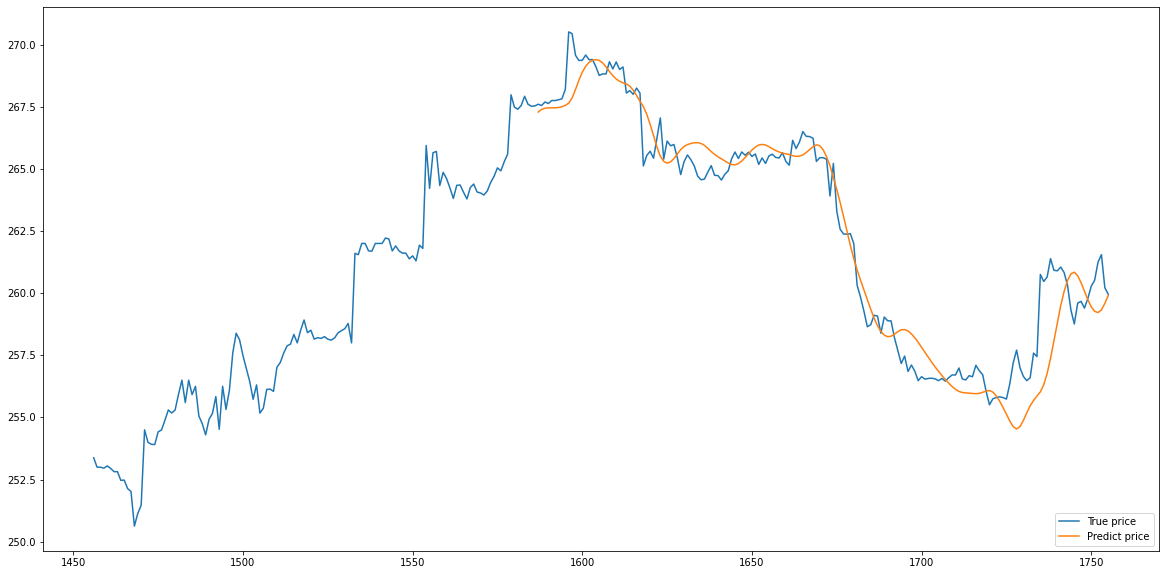

In [146]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/25
43/43 [==============================] - 32s 412ms/step - loss: 0.0419 - val_loss: 0.0036
Epoch 2/25
43/43 [==============================] - 16s 373ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 3/25
43/43 [==============================] - 17s 403ms/step - loss: 0.0085 - val_loss: 0.0033
Epoch 4/25
43/43 [==============================] - 16s 375ms/step - loss: 0.0076 - val_loss: 0.0029
Epoch 5/25
43/43 [==============================] - 16s 379ms/step - loss: 0.0073 - val_loss: 0.0038
Epoch 6/25
43/43 [==============================] - 17s 393ms/step - loss: 0.0075 - val_loss: 0.0047
Epoch 7/25
43/43 [==============================] - 16s 376ms/step - loss: 0.0067 - val_loss: 0.0024
Epoch 8/25
43/43 [==============================] - 16s 383ms/step - loss: 0.0066 - val_loss: 0.0025
Epoch 9/25
43/43 [==============================] - 17s 384ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 10/25
43/43 [==============================] - 16s 378ms/step - loss: 0.0056 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


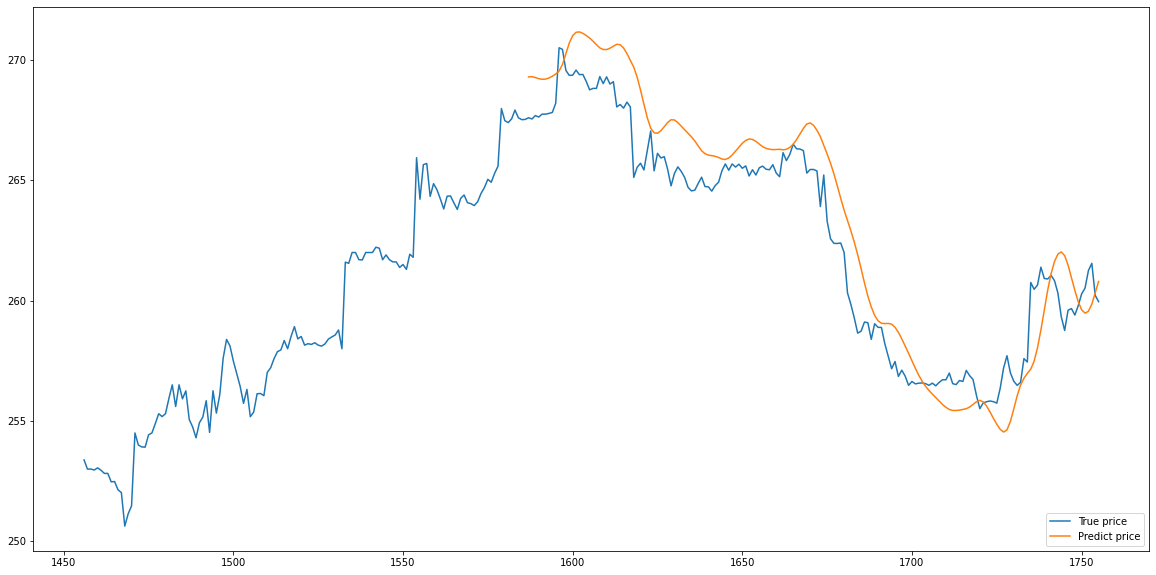

In [147]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/25
43/43 [==============================] - 38s 447ms/step - loss: 0.0425 - val_loss: 0.0050
Epoch 2/25
43/43 [==============================] - 17s 393ms/step - loss: 0.0100 - val_loss: 0.0036
Epoch 3/25
43/43 [==============================] - 17s 391ms/step - loss: 0.0083 - val_loss: 0.0035
Epoch 4/25
43/43 [==============================] - 17s 404ms/step - loss: 0.0079 - val_loss: 0.0035
Epoch 5/25
43/43 [==============================] - 17s 394ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 6/25
43/43 [==============================] - 17s 394ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 7/25
43/43 [==============================] - 17s 391ms/step - loss: 0.0058 - val_loss: 0.0032
Epoch 8/25
43/43 [==============================] - 17s 389ms/step - loss: 0.0052 - val_loss: 0.0038
Epoch 9/25
43/43 [==============================] - 17s 403ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 10/25
43/43 [==============================] - 17s 394ms/step - loss: 0.0053 - val_lo

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


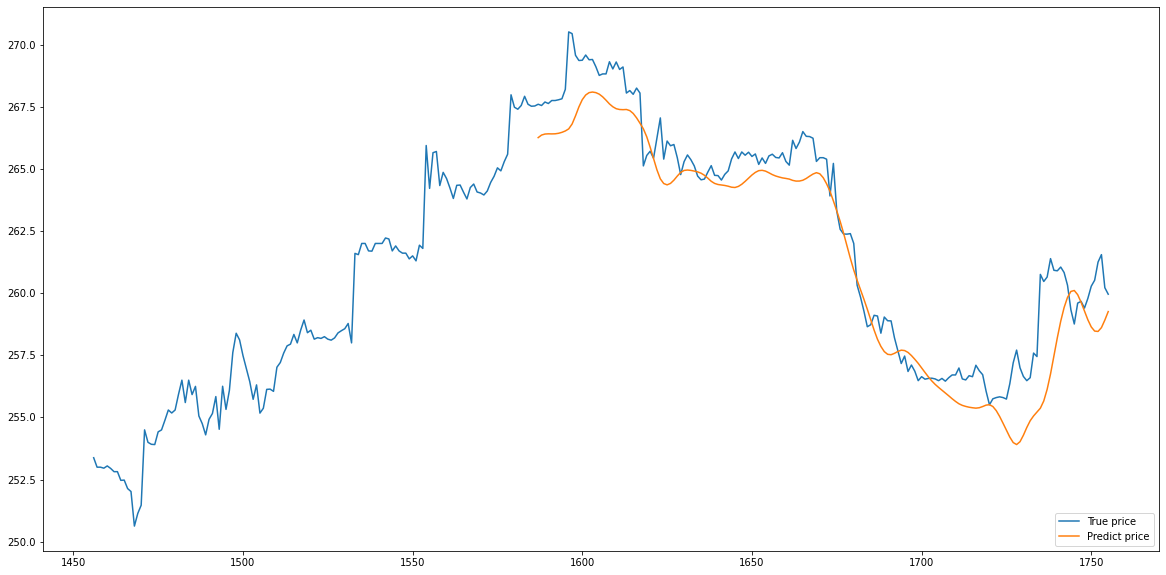

In [148]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

## 3. XGBOOST

### a. Prepare Input

In [149]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume']]
dataset

close     volume
0     261.7200  1550136.0
1     261.2620  1017808.0
2     261.7400   935980.0
3     260.6400  1031814.0
4     260.0900   739633.0
...        ...        ...
1751  260.5200   283685.0
1752  261.2500   554627.0
1753  261.5501   437153.0
1754  260.2200   439656.0
1755  259.9587   463893.0

[1756 rows x 2 columns]

In [150]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
dataset

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close     volume  close_date_1  volume_date_1  close_date_2  \
0     261.7200  1550136.0           NaN            NaN           NaN   
1     261.2620  1017808.0      261.7200      1550136.0           NaN   
2     261.7400   935980.0      261.2620      1017808.0      261.7200   
3     260.6400  1031814.0      261.7400       935980.0      261.2620   
4     260.0900   739633.0      260.6400      1031814.0      261.7400   
...        ...        ...           ...            ...           ...   
1751  260.5200   283685.0      260.2800       365326.0      259.7900   
1752  261.2500   554627.0      260.5200       283685.0      260.2800   
1753  261.5501   437153.0      261.2500       554627.0      260.5200   
1754  260.2200   439656.0      261.5501       437153.0      261.2500   
1755  259.9587   463893.0      260.2200       439656.0      261.5501   

      volume_date_2  
0               NaN  
1               NaN  
2         1550136.0  
3         1017808.0  
4          935980.0  
...             ...  
1751       374950.0  
1752       365326.0  
1753       283685.0  
1754       554627.0  
1755       437153.0  

[1756 rows x 6 columns]

In [151]:
dataset.dropna(inplace=True)
dataset

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


close     volume  close_date_1  volume_date_1  close_date_2  \
2     261.7400   935980.0      261.2620      1017808.0      261.7200   
3     260.6400  1031814.0      261.7400       935980.0      261.2620   
4     260.0900   739633.0      260.6400      1031814.0      261.7400   
5     260.3000   630506.0      260.0900       739633.0      260.6400   
6     259.2800   595587.0      260.3000       630506.0      260.0900   
...        ...        ...           ...            ...           ...   
1751  260.5200   283685.0      260.2800       365326.0      259.7900   
1752  261.2500   554627.0      260.5200       283685.0      260.2800   
1753  261.5501   437153.0      261.2500       554627.0      260.5200   
1754  260.2200   439656.0      261.5501       437153.0      261.2500   
1755  259.9587   463893.0      260.2200       439656.0      261.5501   

      volume_date_2  
2         1550136.0  
3         1017808.0  
4          935980.0  
5         1031814.0  
6          739633.0  
...             ...  
1751       374950.0  
1752       365326.0  
1753       283685.0  
1754       554627.0  
1755       437153.0  

[1754 rows x 6 columns]

In [152]:
X = dataset.drop(['close', 'volume'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1754, 4)
(1754, 1)


close_date_1  volume_date_1  close_date_2  volume_date_2
2         261.2620      1017808.0      261.7200      1550136.0
3         261.7400       935980.0      261.2620      1017808.0
4         260.6400      1031814.0      261.7400       935980.0
5         260.0900       739633.0      260.6400      1031814.0
6         260.3000       630506.0      260.0900       739633.0
...            ...            ...           ...            ...
1751      260.2800       365326.0      259.7900       374950.0
1752      260.5200       283685.0      260.2800       365326.0
1753      261.2500       554627.0      260.5200       283685.0
1754      261.5501       437153.0      261.2500       554627.0
1755      260.2200       439656.0      261.5501       437153.0

[1754 rows x 4 columns]

In [153]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1579, 4)
Size test:  (175, 4)


### b. Train Model

In [154]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST.dat", "wb"))

### c. Test Model

In [155]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST.dat", "rb"))

In [156]:
predictions = model_xgboost.predict(X_test)
predictions

array([267.70273, 267.79773, 267.6615 , 268.183  , 267.9667 , 267.48746,
       267.6891 , 268.23267, 267.59894, 267.94528, 268.5486 , 268.39136,
       268.52222, 268.13007, 268.25272, 267.91235, 270.23212, 270.28455,
       269.7296 , 269.663  , 269.54114, 269.52243, 269.28012, 269.25262,
       269.22446, 268.54962, 269.11813, 268.63232, 269.48618, 268.90018,
       268.8866 , 268.6272 , 269.09085, 267.96213, 268.251  , 268.0088 ,
       268.1043 , 267.88477, 265.87857, 266.155  , 266.30423, 265.9895 ,
       266.2176 , 266.8248 , 266.96484, 266.0624 , 265.82687, 265.87326,
       266.07736, 265.2401 , 264.47928, 266.42822, 266.116  , 265.3263 ,
       264.99292, 264.23578, 264.1867 , 264.7182 , 264.6471 , 265.29318,
       264.0689 , 264.18784, 264.46738, 264.6385 , 265.152  , 265.66122,
       265.8254 , 266.20798, 266.01025, 265.8461 , 266.30582, 266.12354,
       265.18115, 266.14893, 265.09442, 266.00998, 266.08197, 265.81693,
       266.38995, 265.9392 , 265.175  , 265.0818 , 

In [157]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close    volume  close_date_1  volume_date_1  close_date_2  \
1581  267.4000  166180.0      267.4800      2871604.0      267.9800   
1582  267.5499   97069.0      267.4000       166180.0      267.4800   
1583  267.9200   24311.0      267.5499        97069.0      267.4000   
1584  267.6000   11233.0      267.9200        24311.0      267.5499   
1585  267.5200   32387.0      267.6000        11233.0      267.9200   
...        ...       ...           ...            ...           ...   
1751  260.5200  283685.0      260.2800       365326.0      259.7900   
1752  261.2500  554627.0      260.5200       283685.0      260.2800   
1753  261.5501  437153.0      261.2500       554627.0      260.5200   
1754  260.2200  439656.0      261.5501       437153.0      261.2500   
1755  259.9587  463893.0      260.2200       439656.0      261.5501   

      volume_date_2  predictions  
1581      3366650.0   267.702728  
1582      2871604.0   267.797729  
1583       166180.0   267.661499  
1584        97069.0   268.183014  
1585        24311.0   267.966705  
...             ...          ...  
1751       374950.0   260.872772  
1752       365326.0   260.872772  
1753       283685.0   260.765808  
1754       554627.0   262.412933  
1755       437153.0   260.874359  

[175 rows x 7 columns]

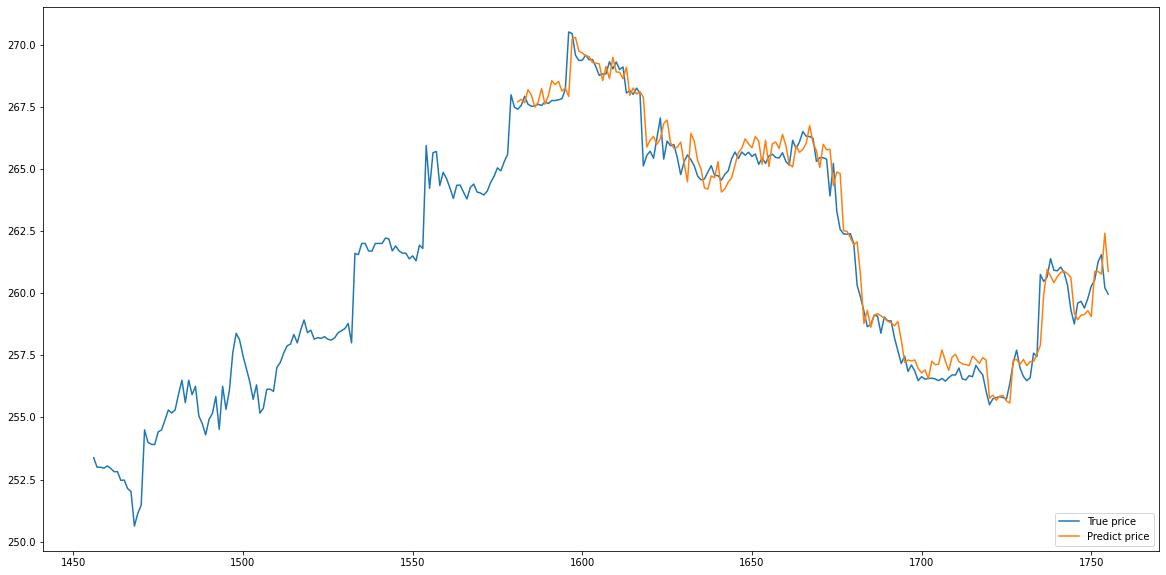

In [158]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [159]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC']]
dataset

close     volume     ROC
0     261.7200  1550136.0 -1.2377
1     261.2620  1017808.0 -1.4106
2     261.7400   935980.0 -1.0884
3     260.6400  1031814.0 -1.6935
4     260.0900   739633.0 -2.0081
...        ...        ...     ...
1751  260.5200   283685.0  1.5752
1752  261.2500   554627.0  1.8122
1753  261.5501   437153.0  1.5374
1754  260.2200   439656.0  1.0759
1755  259.9587   463893.0 -0.3054

[1756 rows x 3 columns]

In [160]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
dataset

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
0     261.7200  1550136.0 -1.2377           NaN            NaN         NaN   
1     261.2620  1017808.0 -1.4106      261.7200      1550136.0     -1.2377   
2     261.7400   935980.0 -1.0884      261.2620      1017808.0     -1.4106   
3     260.6400  1031814.0 -1.6935      261.7400       935980.0     -1.0884   
4     260.0900   739633.0 -2.0081      260.6400      1031814.0     -1.6935   
...        ...        ...     ...           ...            ...         ...   
1751  260.5200   283685.0  1.5752      260.2800       365326.0      1.4144   
1752  261.2500   554627.0  1.8122      260.5200       283685.0      1.5752   
1753  261.5501   437153.0  1.5374      261.2500       554627.0      1.8122   
1754  260.2200   439656.0  1.0759      261.5501       437153.0      1.5374   
1755  259.9587   463893.0 -0.3054      260.2200       439656.0      1.0759   

      close_date_2  volume_date_2  ROC_date_2  
0              NaN            NaN         NaN  
1              NaN            NaN         NaN  
2         261.7200      1550136.0     -1.2377  
3         261.2620      1017808.0     -1.4106  
4         261.7400       935980.0     -1.0884  
...            ...            ...         ...  
1751      259.7900       374950.0      1.0856  
1752      260.2800       365326.0      1.4144  
1753      260.5200       283685.0      1.5752  
1754      261.2500       554627.0      1.8122  
1755      261.5501       437153.0      1.5374  

[1756 rows x 9 columns]

In [161]:
dataset.dropna(inplace=True)
dataset

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
2     261.7400   935980.0 -1.0884      261.2620      1017808.0     -1.4106   
3     260.6400  1031814.0 -1.6935      261.7400       935980.0     -1.0884   
4     260.0900   739633.0 -2.0081      260.6400      1031814.0     -1.6935   
5     260.3000   630506.0 -1.7958      260.0900       739633.0     -2.0081   
6     259.2800   595587.0 -2.3427      260.3000       630506.0     -1.7958   
...        ...        ...     ...           ...            ...         ...   
1751  260.5200   283685.0  1.5752      260.2800       365326.0      1.4144   
1752  261.2500   554627.0  1.8122      260.5200       283685.0      1.5752   
1753  261.5501   437153.0  1.5374      261.2500       554627.0      1.8122   
1754  260.2200   439656.0  1.0759      261.5501       437153.0      1.5374   
1755  259.9587   463893.0 -0.3054      260.2200       439656.0      1.0759   

      close_date_2  volume_date_2  ROC_date_2  
2         261.7200      1550136.0     -1.2377  
3         261.2620      1017808.0     -1.4106  
4         261.7400       935980.0     -1.0884  
5         260.6400      1031814.0     -1.6935  
6         260.0900       739633.0     -2.0081  
...            ...            ...         ...  
1751      259.7900       374950.0      1.0856  
1752      260.2800       365326.0      1.4144  
1753      260.5200       283685.0      1.5752  
1754      261.2500       554627.0      1.8122  
1755      261.5501       437153.0      1.5374  

[1754 rows x 9 columns]

In [162]:
X = dataset.drop(['close', 'volume', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1754, 6)
(1754, 1)


close_date_1  volume_date_1  ROC_date_1  close_date_2  volume_date_2  \
2         261.2620      1017808.0     -1.4106      261.7200      1550136.0   
3         261.7400       935980.0     -1.0884      261.2620      1017808.0   
4         260.6400      1031814.0     -1.6935      261.7400       935980.0   
5         260.0900       739633.0     -2.0081      260.6400      1031814.0   
6         260.3000       630506.0     -1.7958      260.0900       739633.0   
...            ...            ...         ...           ...            ...   
1751      260.2800       365326.0      1.4144      259.7900       374950.0   
1752      260.5200       283685.0      1.5752      260.2800       365326.0   
1753      261.2500       554627.0      1.8122      260.5200       283685.0   
1754      261.5501       437153.0      1.5374      261.2500       554627.0   
1755      260.2200       439656.0      1.0759      261.5501       437153.0   

      ROC_date_2  
2        -1.2377  
3        -1.4106  
4        -1.0884  
5        -1.6935  
6        -2.0081  
...          ...  
1751      1.0856  
1752      1.4144  
1753      1.5752  
1754      1.8122  
1755      1.5374  

[1754 rows x 6 columns]

In [163]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1579, 6)
Size test:  (175, 6)


In [164]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC.dat", "wb"))

In [165]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC.dat", "rb"))

In [166]:
predictions = model_xgboost.predict(X_test)
predictions

array([267.6608 , 267.41605, 267.3382 , 268.1526 , 267.64478, 267.30353,
       267.31516, 268.2171 , 267.31522, 267.75385, 268.12146, 268.20343,
       268.3388 , 267.97516, 267.81396, 267.82507, 269.815  , 270.11224,
       269.7709 , 269.8224 , 269.03735, 269.37994, 269.02997, 269.14822,
       269.02762, 268.52814, 268.80966, 268.698  , 269.0995 , 268.9121 ,
       269.0126 , 268.39862, 268.856  , 267.70703, 267.4819 , 267.70844,
       267.37958, 267.45697, 265.7881 , 266.50665, 266.32523, 265.98306,
       266.12112, 266.80475, 266.9919 , 266.05856, 266.00302, 266.11105,
       265.99454, 264.4365 , 263.8006 , 266.28412, 265.67203, 265.45322,
       264.7148 , 263.9637 , 263.90347, 264.54813, 264.68344, 264.86673,
       264.24075, 263.90036, 263.96243, 264.62622, 265.82922, 265.9555 ,
       266.28342, 266.2506 , 266.0392 , 265.92676, 266.3911 , 266.39978,
       265.43588, 266.45413, 265.0582 , 266.15347, 266.04193, 266.206  ,
       266.45474, 265.77054, 265.21014, 265.09256, 

In [167]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close    volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
1581  267.4000  166180.0  1.1997      267.4800      2871604.0      1.0846   
1582  267.5499   97069.0  1.4176      267.4000       166180.0      1.1997   
1583  267.9200   24311.0  1.3549      267.5499        97069.0      1.4176   
1584  267.6000   11233.0  1.2294      267.9200        24311.0      1.3549   
1585  267.5200   32387.0  1.3103      267.6000        11233.0      1.2294   
...        ...       ...     ...           ...            ...         ...   
1751  260.5200  283685.0  1.5752      260.2800       365326.0      1.4144   
1752  261.2500  554627.0  1.8122      260.5200       283685.0      1.5752   
1753  261.5501  437153.0  1.5374      261.2500       554627.0      1.8122   
1754  260.2200  439656.0  1.0759      261.5501       437153.0      1.5374   
1755  259.9587  463893.0 -0.3054      260.2200       439656.0      1.0759   

      close_date_2  volume_date_2  ROC_date_2  predictions  
1581      267.9800      3366650.0      1.1780   267.660797  
1582      267.4800      2871604.0      1.0846   267.416046  
1583      267.4000       166180.0      1.1997   267.338196  
1584      267.5499        97069.0      1.4176   268.152588  
1585      267.9200        24311.0      1.3549   267.644775  
...            ...            ...         ...          ...  
1751      259.7900       374950.0      1.0856   261.103668  
1752      260.2800       365326.0      1.4144   260.945587  
1753      260.5200       283685.0      1.5752   260.609772  
1754      261.2500       554627.0      1.8122   261.939697  
1755      261.5501       437153.0      1.5374   260.772522  

[175 rows x 10 columns]

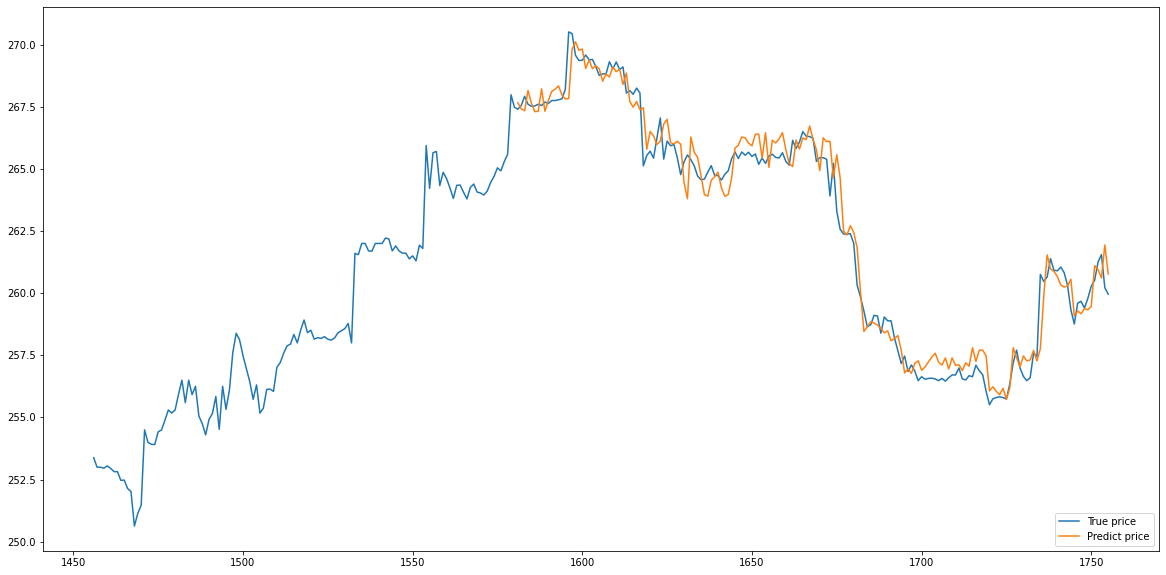

In [168]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/thupham/Documents/CNM_CNPM/stock-prediction-project/venv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


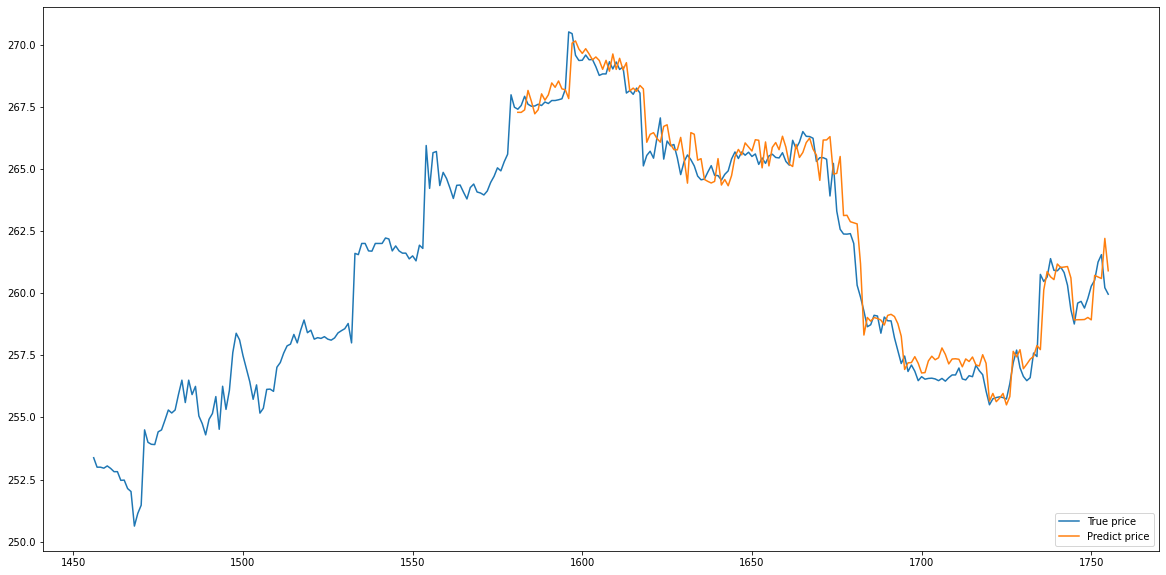

In [169]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

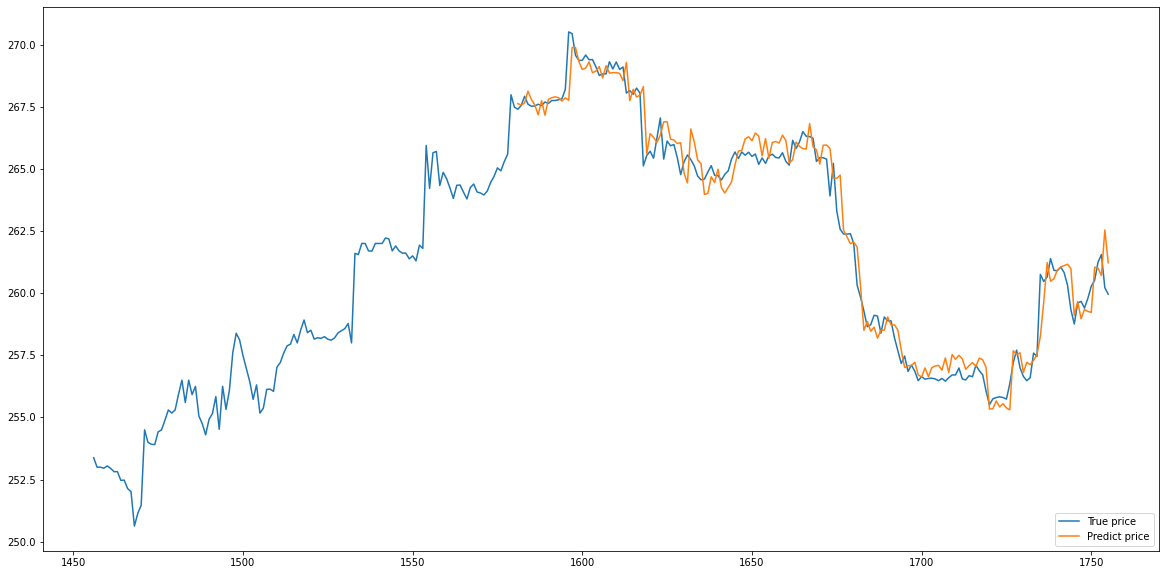

In [170]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

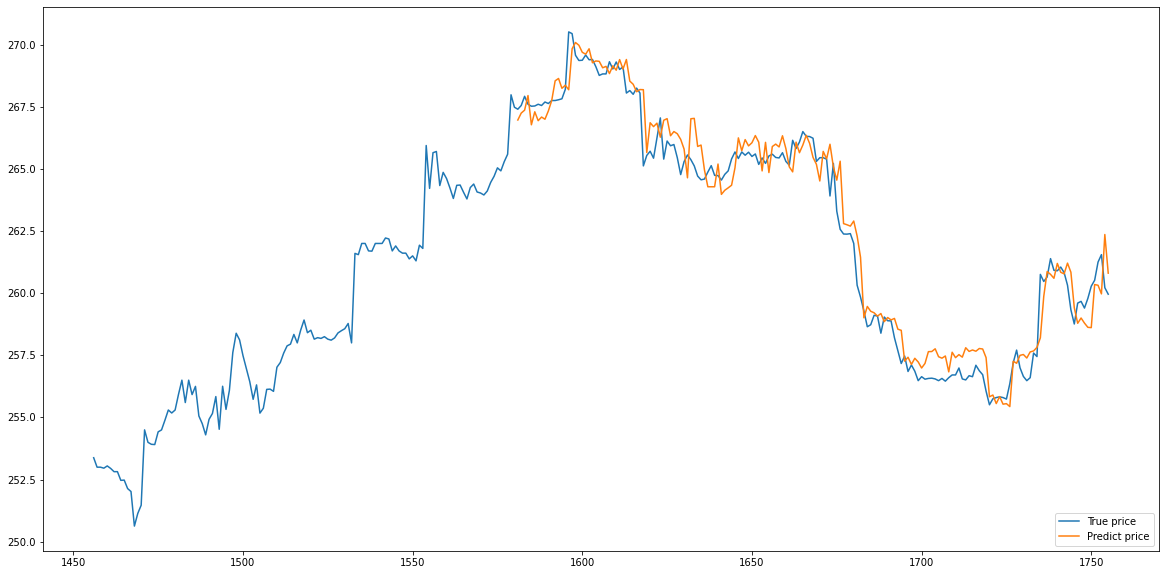

In [171]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)


dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

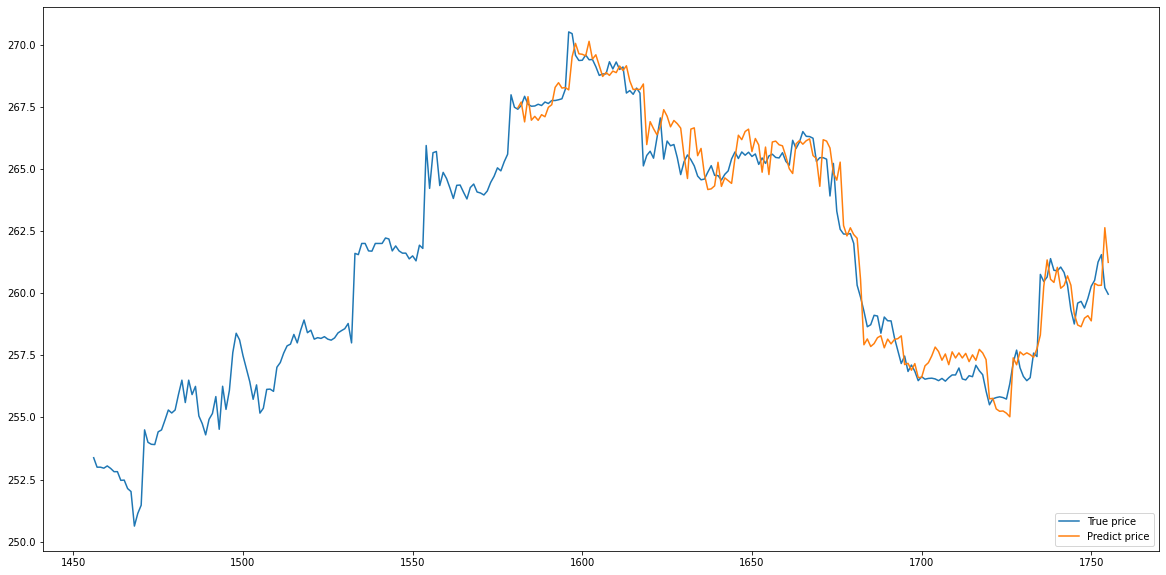

In [172]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

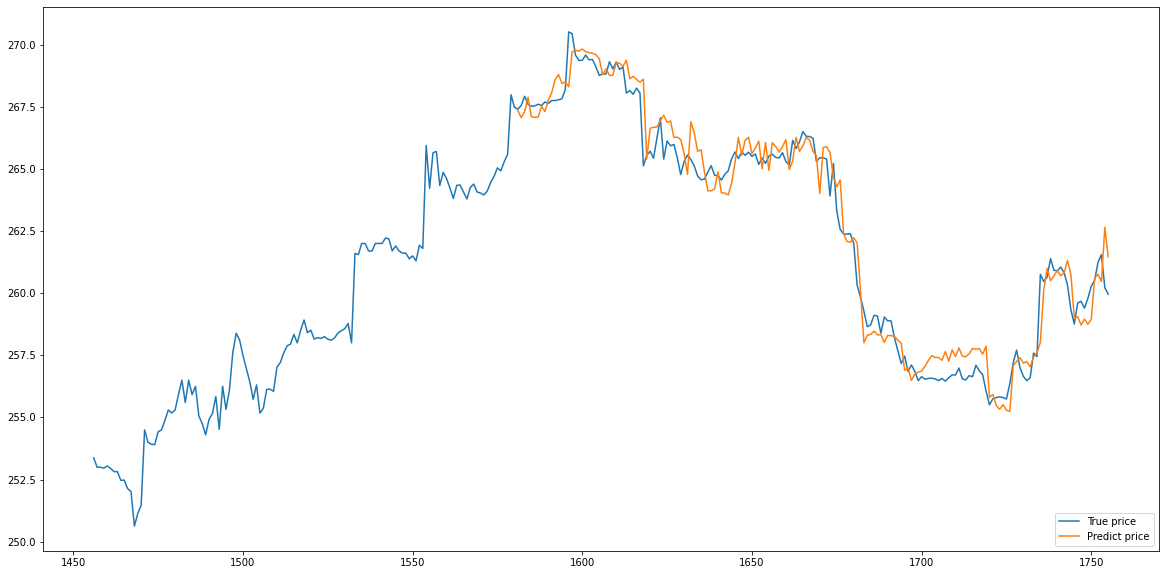

In [173]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

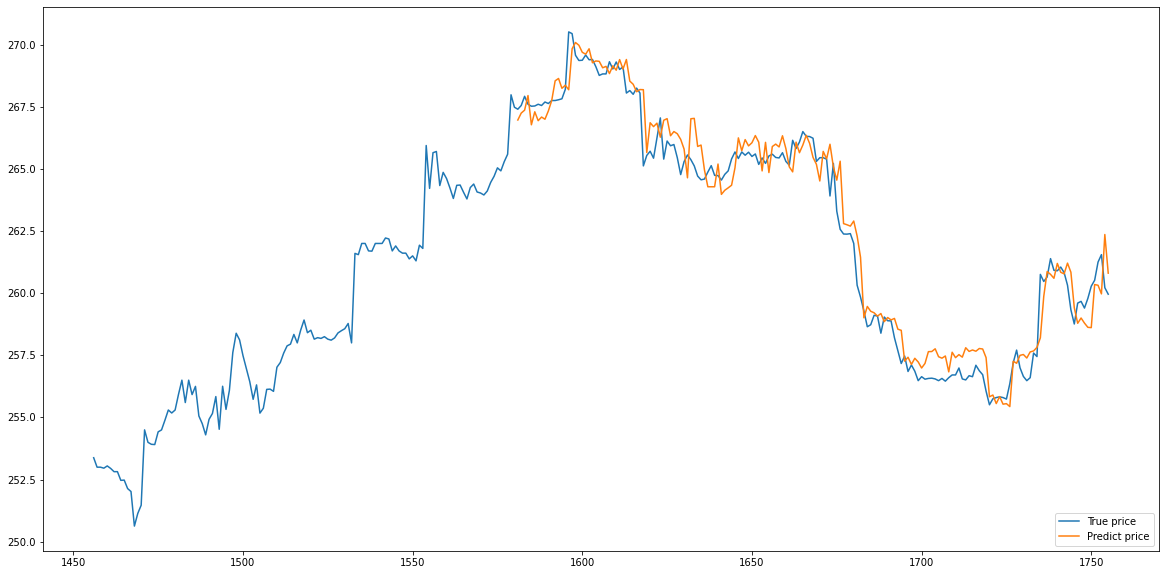

In [174]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

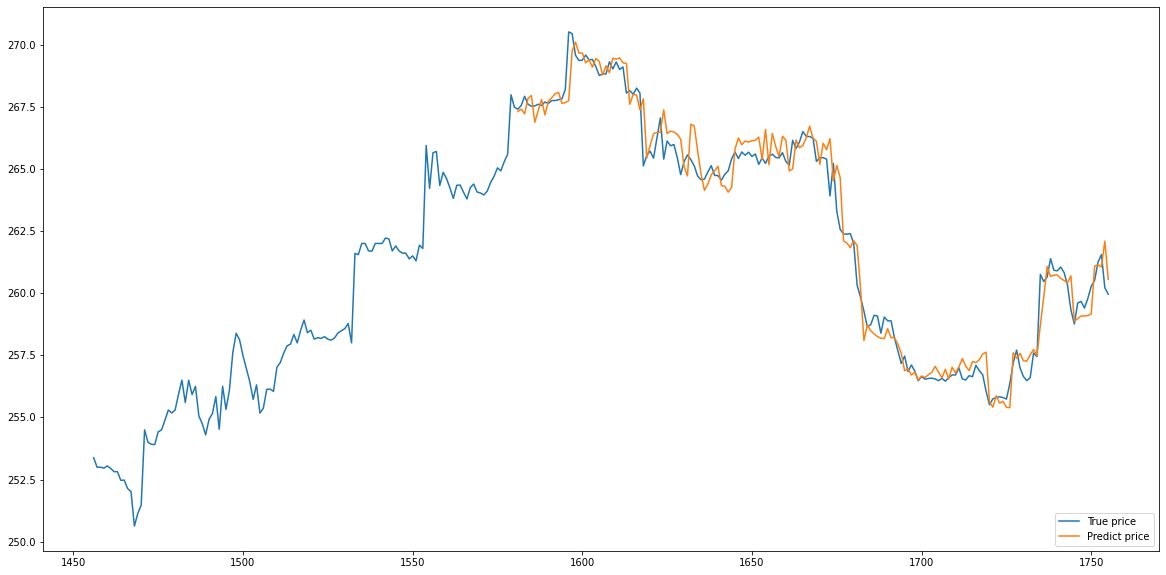

In [175]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

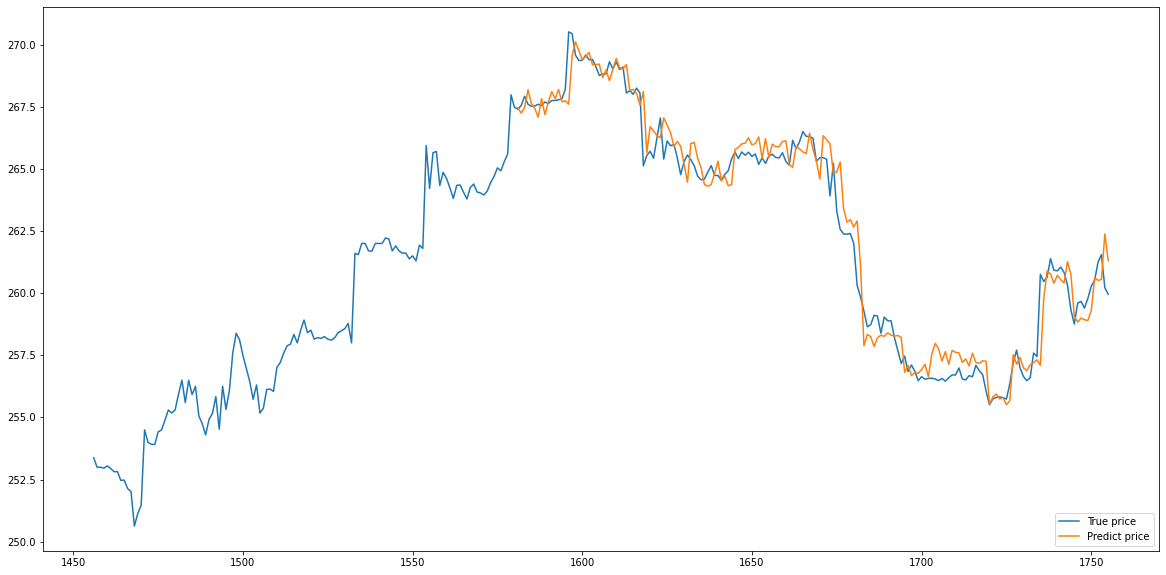

In [176]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

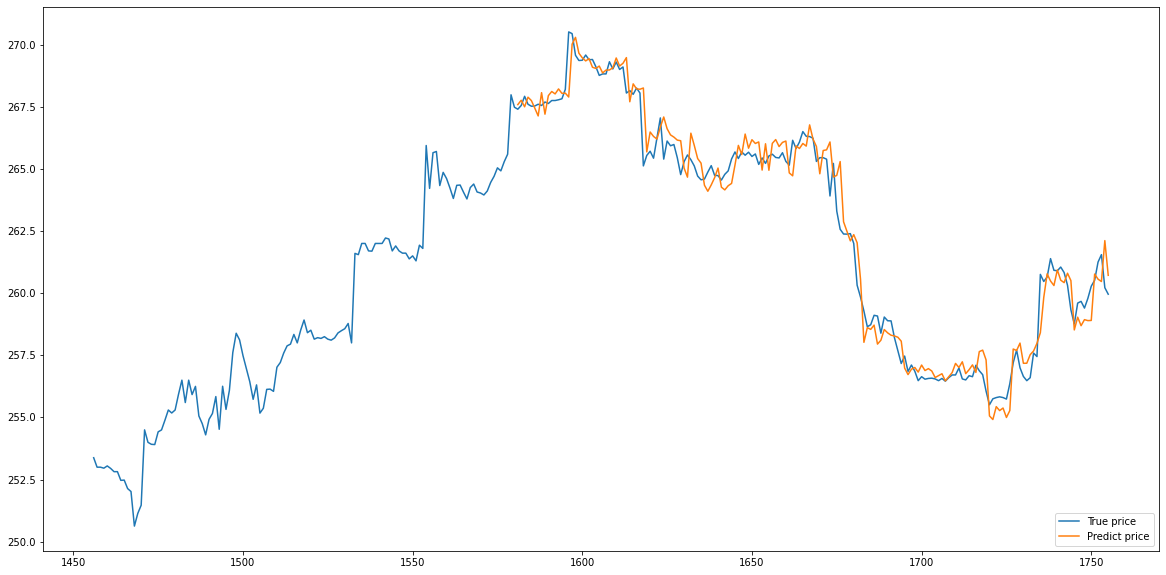

In [177]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

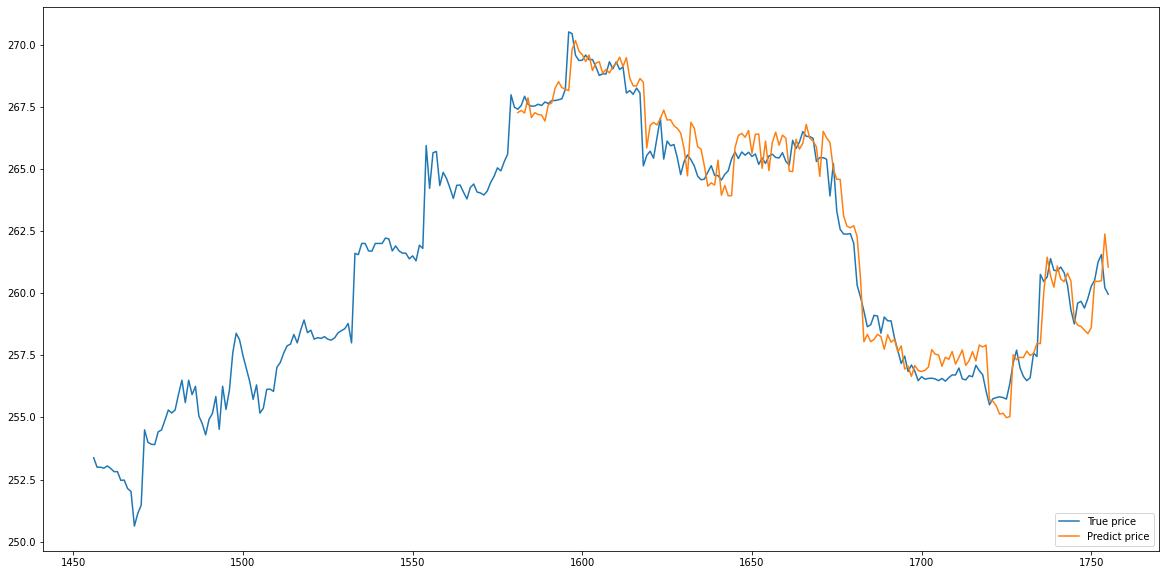

In [178]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

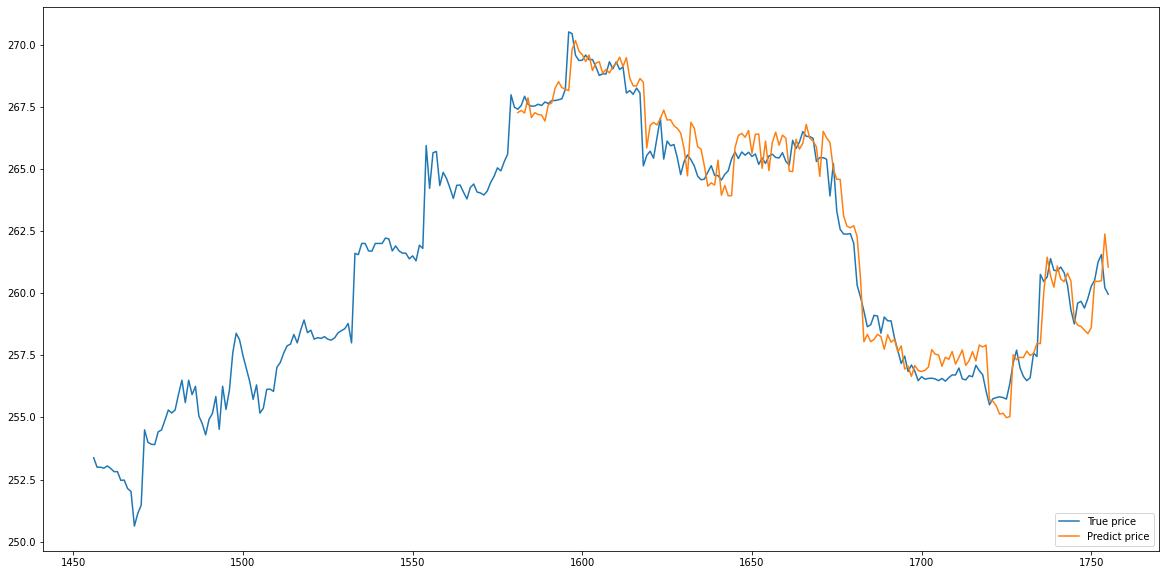

In [179]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

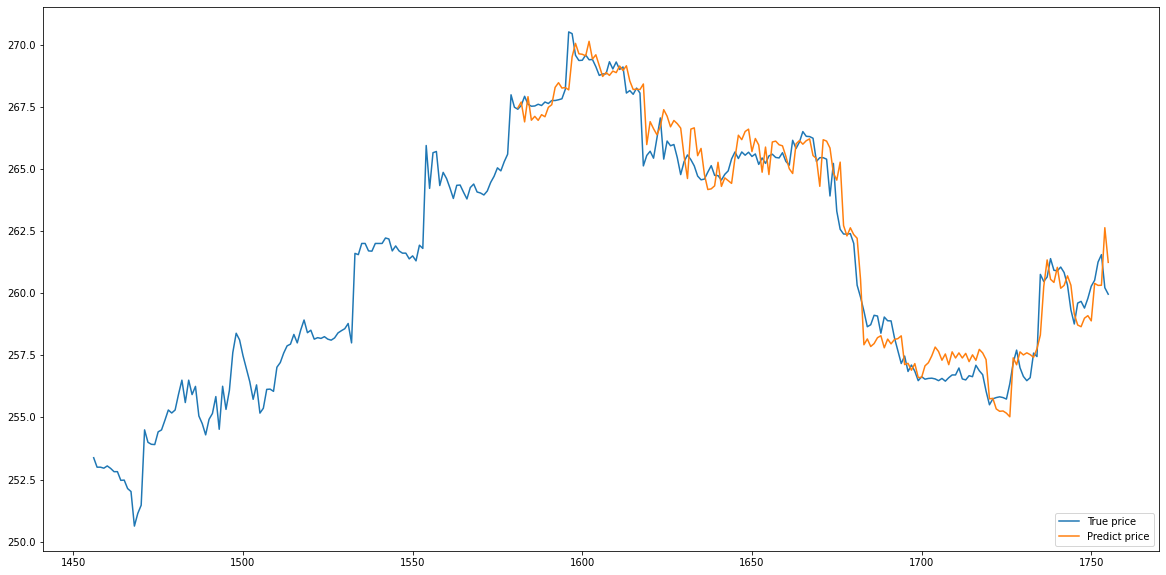

In [180]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

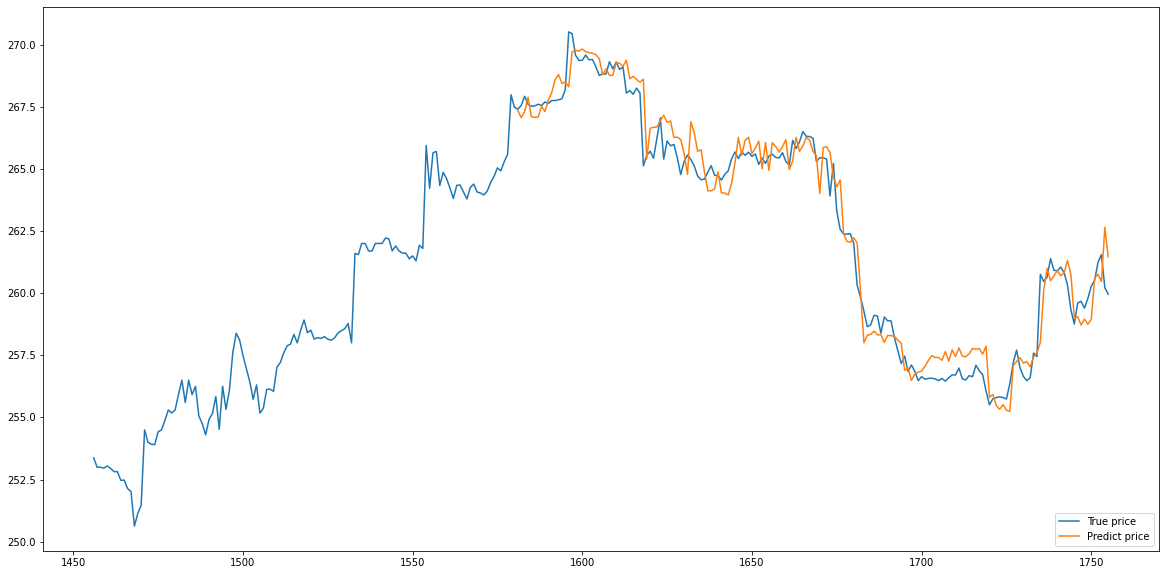

In [181]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

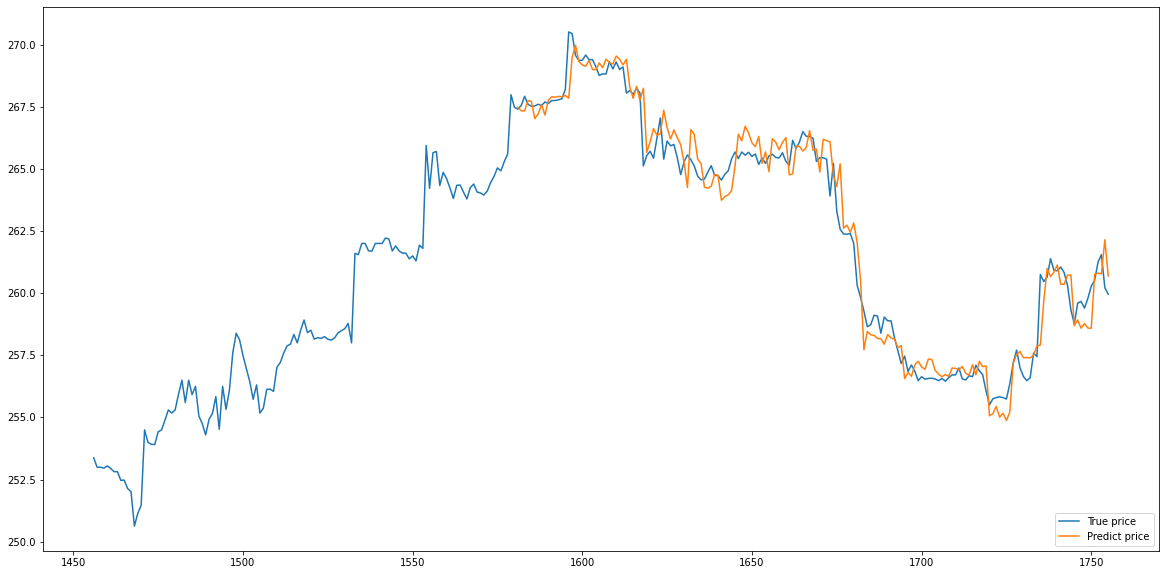

In [182]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

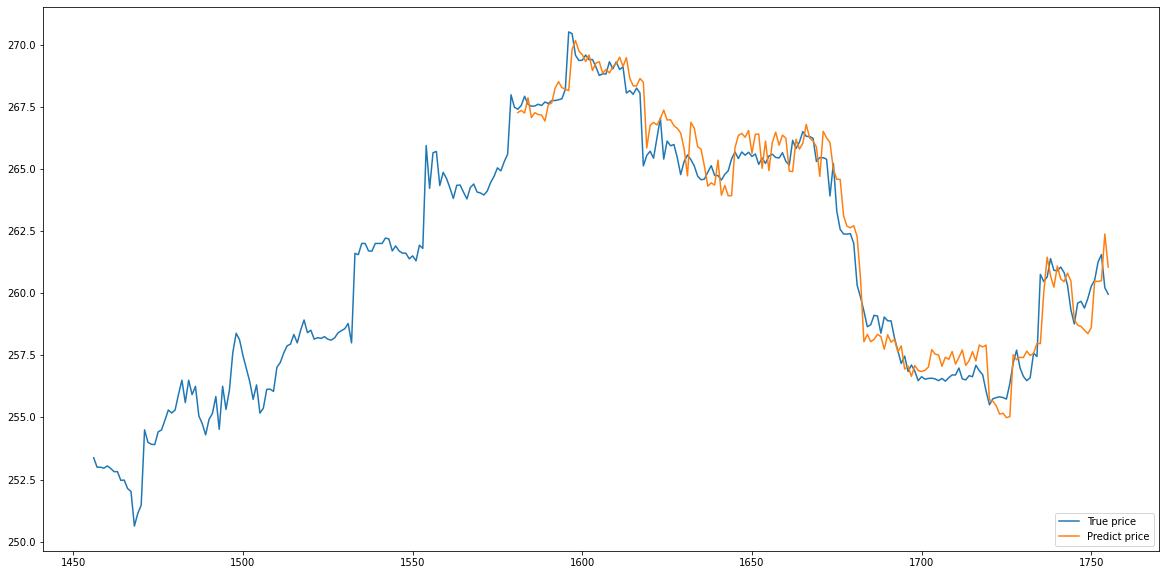

In [183]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### Predict Future

In [184]:
def xgboost_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.dat'
    model = pickle.load(open(modelFileName, "rb"))
    numDataPoint = int(period / 15)
    
    temp = indicatorArr.copy()
    temp.append('volume')
    data = data[temp]
    data = data[-5:]
    
    X = pd.DataFrame({})
    for column in data.columns:
        n = len(data)
        for i in range(1, n + 1):
            X[column + '_date_' + str(i)] = [data.iloc[n - i][column]] 
    
    predictedValue = model.predict(X)
    
    return predictedValue